# Objectives

1. Clock Model:  
  A. Strict Clock: Root-to-Tip Regression on Date  
  B. Relaxed Clock: Rate Variation Histogram  
  C. Tree Prior: Coalescent Skyline  
1. Dating Overview  
  A. Tip Dates
  B. Clade MRCA Dates
  C. Historical Nodes 
1. Plot Timetree: Phylo
1. Plot Divtree: Phylo

---
# Setup

## Import Modules

In [19]:
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec, collections, patches
import pandas as pd

import random
import json # Read clock model data
import scipy.stats # Regression line
import math

from Bio import Phylo

import dill

from treetime.treetime import plot_vs_years 
from treetime.wrappers import print_save_plot_skyline

from scipy.interpolate import UnivariateSpline

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_DIR_NAME = "clock"
PREV_SCRIPT_NAME = "clock_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

sns.set_style("ticks")

## Input File Paths

In [3]:
results_dir = os.path.join(project_dir, "results")
config_dir = os.path.join(results_dir, "config")



outdir       = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_plot"

tree_dill:	 /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model_timetree.treetime.obj
tree_df_dill:	 /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model.df.obj
aln path:	 /2/scratch/keaton/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /2/scratch/keaton/plague-phylogeography/results/config/auspice_config.json
auspice_remote_dir_path: /2/scratch/keaton/plague-phylogeography/auspice/
outdir: /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5


## Import Dataframe

In [4]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,0.001,15.5417,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.979050e-09,1.000000,1.000000e-03,-4103-10-12,-4102.220524,"[-4180.578510747386, -3895.1038959403695]","[6201.578510747386, 5916.1038959403695]",0.100000,0.100000,15.54165,-4102.220524,0.000000,False
SAMEA3541827,NA,NA,3.8408e-06,grey,0.00100322,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.611115e-09,0.290801,3.224760e-06,-2888-03-08,-2887.818131,"[-2876.0, -2677.0]","[4897.0, 4698.0]",1214.402393,1214.502393,1.00000,-2776.500000,0.000003,False
NODE1,100,84.9,1.34224e-05,black,0.00100818,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.168793e-08,1.301689,8.175195e-06,-3404-07-23,-3403.443258,"[-3466.715522662666, -3238.8467118910744]","[5487.7155226626655, 5259.846711891074]",698.777266,698.877266,3.15625,-3403.443258,0.000008,False
SAMEA104233046,NA,NA,2.233e-06,grey,0.00101033,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.377650e-09,0.264800,2.150064e-06,-2609-09-09,-2608.311091,"[-2621.0, -2479.925404147025]","[4642.0, 4500.925404147025]",795.132167,1494.009433,2.00000,-2546.500000,0.000010,False
NODE2,100,94.7,1.34762e-05,black,0.00102239,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.869167e-08,2.081698,1.421276e-05,-2649-12-29,-2648.005752,"[-2718.3352811229283, -2587.2567272696483]","[4739.335281122929, 4608.256727269649]",755.437505,1454.314772,4.31250,-2648.005752,0.000022,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000400,NA,NA,NA,NA,0.0010682,593.344,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.979050e-09,1.000000,1.546651e-19,1977-09-04,1977.675250,"[1974.1059701352367, 1978.8870756560866]","[46.8940298647633, 42.11292434391339]",0.580535,6079.995774,593.34375,1977.675250,0.000068,False
NODE_0000403,NA,NA,NA,NA,0.0010682,594.938,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.296192e-09,0.367098,1.546651e-19,1981-11-29,1981.910174,"[1974.6325274740634, 1989.5353597641172]","[46.36747252593659, 31.464640235882825]",4.234924,6084.230698,594.93750,1981.910174,0.000068,False
NODE_0000404,NA,NA,NA,NA,0.0010682,595.875,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.946020e-09,0.996321,1.546651e-19,1982-10-07,1982.766650,"[1974.9680222709478, 1989.287253116348]","[46.03197772905219, 31.712746883652017]",0.856477,6085.087174,595.87500,1982.766650,0.000068,False


## Import Tree

In [5]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

In [6]:
tt.clock_model

{'slope': 8.979050496468202e-09,
 'intercept': 4.078614412248201e-05,
 'chisq': 553.0124650973921,
 'hessian': array([[ 7.47598485e+18, -8.25465612e+14],
        [-8.25465612e+14,  7.21590416e+11]]),
 'cov': array([[1.53099713e-19, 1.75138895e-16],
        [1.75138895e-16, 1.58617840e-12]]),
 'r_val': 0.5582459801541269,
 'valid_confidence': True}

## Import Colors Dataframe

In [7]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

,Attribute,State,Color
0,branch_number,0,#8000ff
1,branch_number,3,#00b4ec
2,branch_number,4,#80ffb4
3,branch_number,2,#ffb462
4,branch_number,1,#ff0000
...,...,...,...
202,province,MSila,#ff1c0e
203,province,State of Mato Grosso,#ff150b
204,province,Midlands,#ff0e07
205,province,La Paz,#ff0704


---
# 1. Clock Model

## A. Strict Clock: Root-to-Tip Regression on Date  

/home/keaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


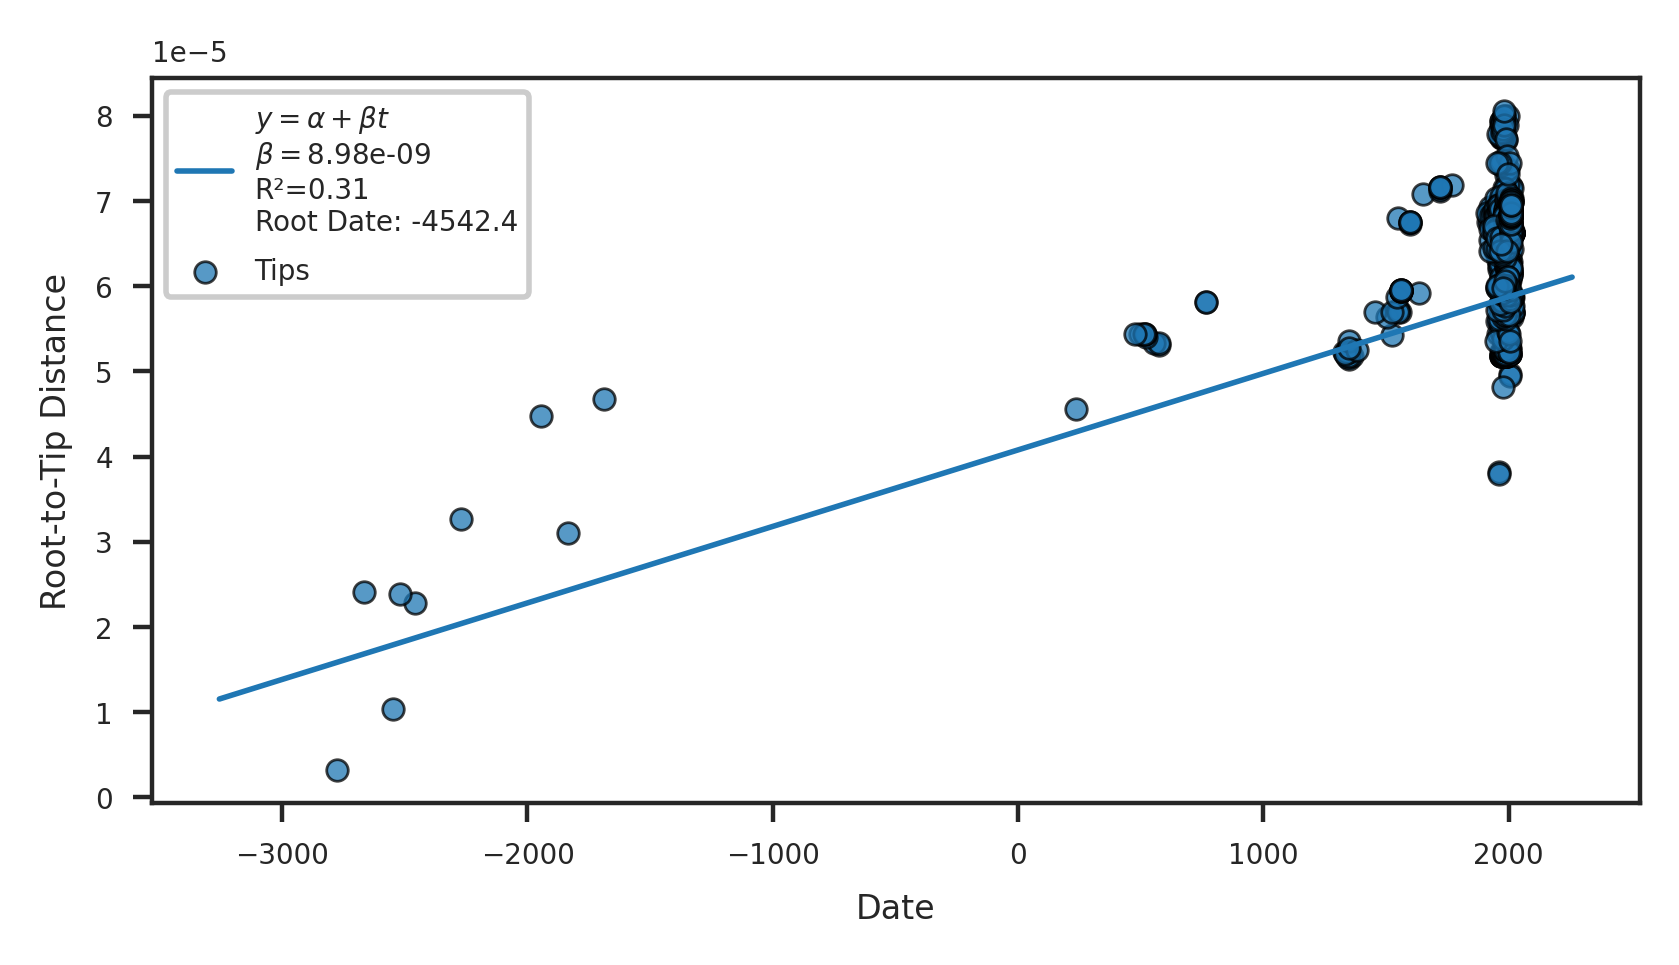

In [126]:
regression = tt.clock_model

# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['slope']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])
res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
"""ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)"""
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[0],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.2f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
         lw=1,
        )

# Labels
ax1.set_xlabel("Date", fontsize=6)
ax1.set_ylabel("Root-to-Tip Distance", fontsize=6)
#ax1.set_title("Root-to-Tip Regression on Date", fontsize=7)
# Legend
#plt.legend(loc=2, frameon = 1, framealpha=1)
plt.legend(bbox_to_anchor=(0,1.00), 
           loc="upper left",
           frameon = 1, 
           framealpha=1)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## B. Relaxed Clock: Rate Variation Histogram  

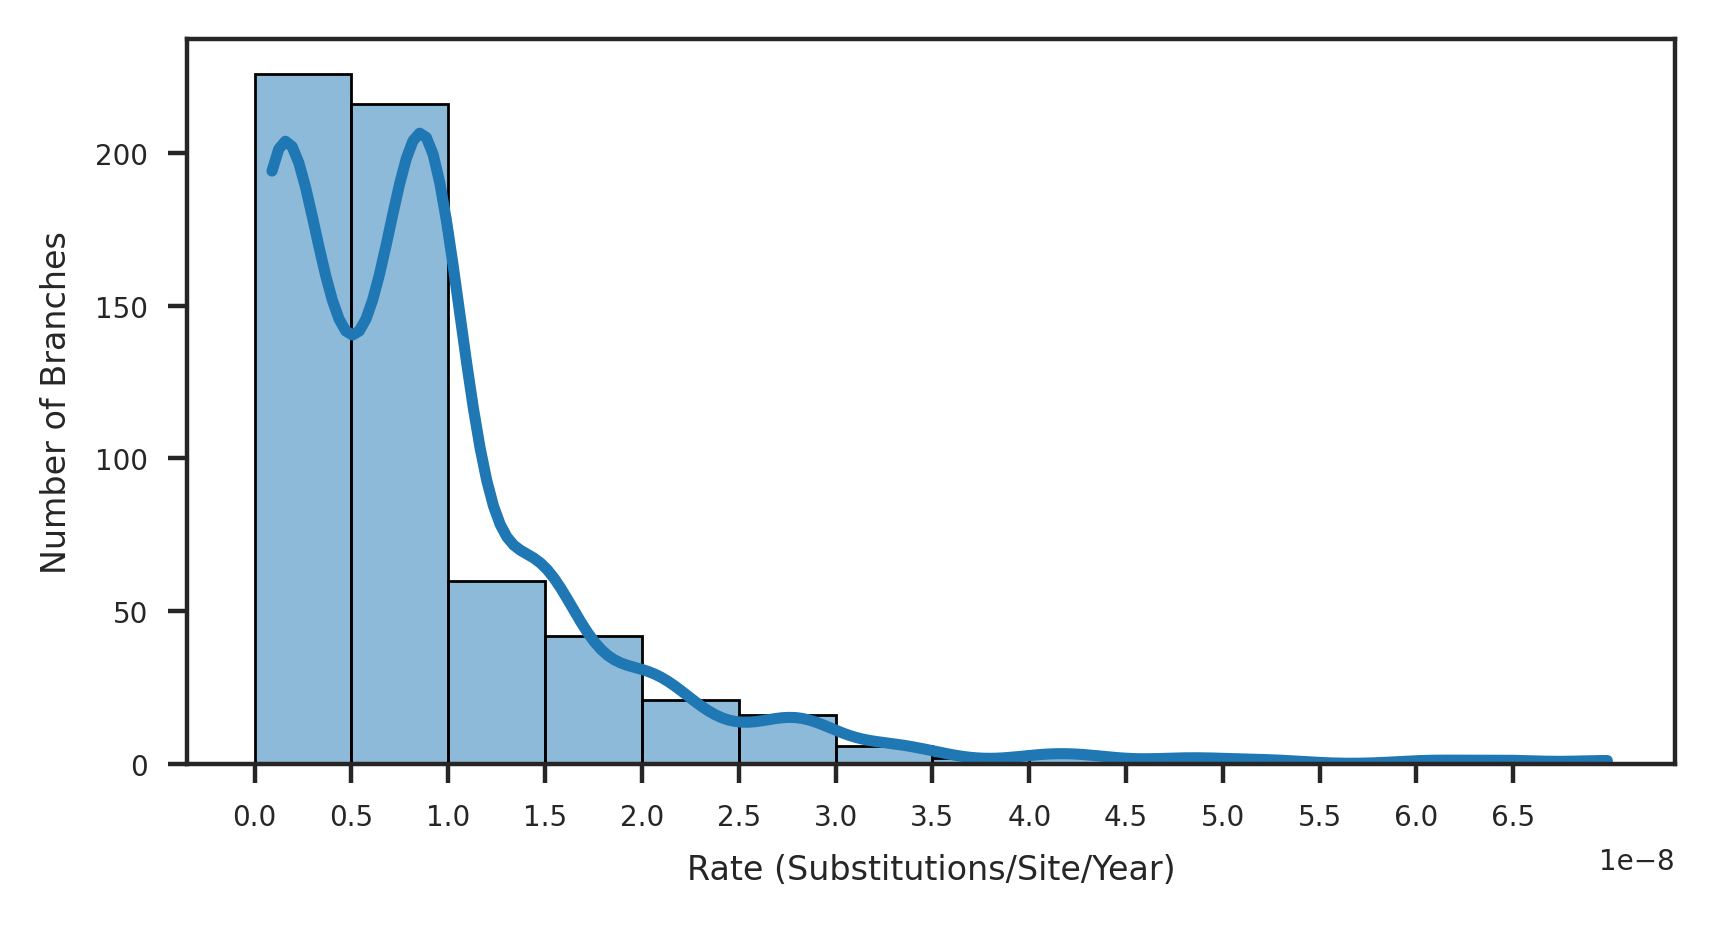

In [127]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the rate histogram
mean_rate = sum(tip_data["timetree_rate"]) / len(tip_data["timetree_rate"])
max_rate = max(tip_data["timetree_rate"])

# If marginal and a relaxed clock used
if mean_rate != max_rate:
    hist_bins = [x/1000000000 for x in range(0,int(max_rate * 1000000000), 5)]
    xticks = hist_bins
else:
    hist_bins = 1
    
    xticks = [mean_rate]
    
sns.histplot(
    x = list(tip_data["timetree_rate"]), 
    ax=ax1, 
    kde=True,
    bins=hist_bins,
    kde_kws={'bw_adjust':0.75,},
    ec="black",
    linewidth=0.5,
)

ax1.set_xticks(xticks)

ax1.set_xlabel("Rate (Substitutions/Site/Year)", fontsize=6)
ax1.set_ylabel("Number of Branches", fontsize=6)
#ax1.set_title("Rate Variation Across Branches", fontsize=7)


# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate-variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")

## C. Tree Prior: Coalescent Skyline  


 --- written skyline to /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_plot_skyline.tsv



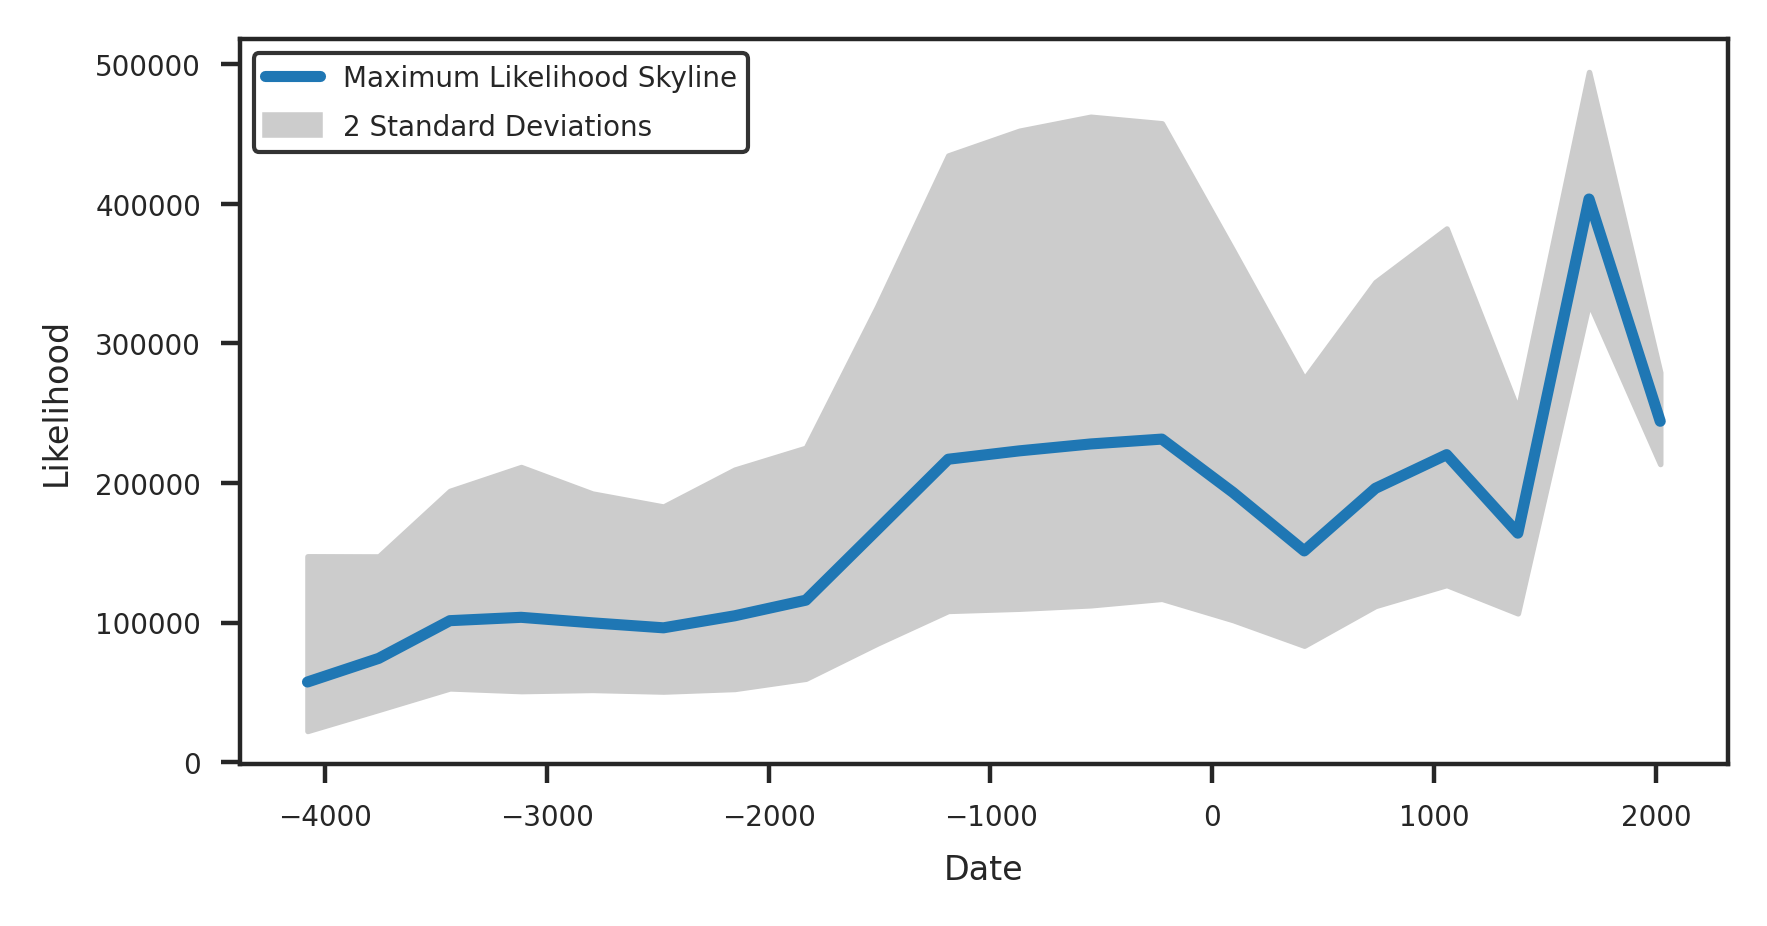

In [128]:
tt_copy = copy.deepcopy(tt)

if hasattr(tt, "merger_model"):
    skyline, conf = tt_copy.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    
    fig, ax1 = plt.subplots(1, 1, figsize=figsize_mini, dpi=dpi, sharey=True)
    #sns.scatterplot(x=skyline.x, y=skyline.y, ax=ax1, s=5, ec="black")
    ax1.fill_between(skyline.x, conf[0], conf[1], color=(0.8, 0.8, 0.8), zorder=1, label="{} Standard Deviations".format(N_STD))
    ax1.plot(skyline.x, skyline.y, label='Maximum Likelihood Skyline')
    ax1.legend(frameon=True, edgecolor="black", loc="upper left")
    ax1.get_legend().get_frame().set_linewidth(0.75)
    ax1.set_xlabel("Date", fontsize=6)
    ax1.set_ylabel("Likelihood", fontsize=6)
    
    out_path_skyline_svg = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )   
    
    plt.savefig(out_path_skyline_svg, dpi=dpi, bbox_inches = "tight")
    print_save_plot_skyline(tt_copy, save=out_path_skyline_txt,screen=False,n_std=N_STD, )

---
# 2. Dating Overview

## A. Tip Dates

### Prep Data

In [130]:
date_df = pd.DataFrame()

for branch_major in colors_dict["branch_major"]:
    branch_color =  colors_dict["branch_major"][branch_major]

    for c in tt.tree.get_terminals():    
        node_branch_major = tree_df["Branch_Major"][c.name]
        if node_branch_major != branch_major: continue          
        node_branch_minor = tree_df["Branch_Minor"][c.name]
        
        # -------------------------------------------
        # Add known date
        known_date = tree_df["Date"][c.name]
        
        if type(known_date) == str:
            known_date_str = known_date.lstrip("[").rstrip("]").split(":")
            known_range = [float(d) for d in known_date_str]
            known_date = sum(known_range) / len(known_range)
        else:
            known_range = [known_date, known_date]
            known_date = sum(known_range) / len(known_range)
            
        df = pd.DataFrame({
            "date": [known_date],
            "date_type": "Known Mean",
            "branch_major": [node_branch_major],
            "branch_minor": [node_branch_minor],
            "color" : [branch_color],
        })              
        date_df = date_df.append(df, ignore_index=True)

        df = pd.DataFrame({
            "date": [d for d in known_range],
            "date_type": ["Known Range" for d in known_range],
            "branch_major": [node_branch_major for d in known_range],
            "branch_minor": [node_branch_minor for d in known_range],
            "color" : [branch_color for d in known_range],            
        })         
        date_df = date_df.append(df, ignore_index=True)  
        
        # -------------------------------------------
        # Add marginal date
        marginal_date = tt.date2dist.to_numdate(c.marginal_pos_LH.peak_pos)
        marginal_range = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        
        df = pd.DataFrame({
            "date": [marginal_date],
            "date_type": "Marginal Peak",
            "branch_major": [node_branch_major],
            "branch_minor": [node_branch_minor],
            "color" : [branch_color],            
        })     
                   
        date_df = date_df.append(df, ignore_index=True)   
        
        df = pd.DataFrame({
            "date": [d for d in marginal_range],
            "date_type": "Marginal Range",
            "branch_major": [node_branch_major for d in marginal_range],
            "branch_minor": [node_branch_minor for d in marginal_range],
            "color" : [branch_color for d in marginal_range],     
        })           
        date_df = date_df.append(df, ignore_index=True)     

display(date_df)

,date,date_type,branch_major,branch_minor,color
0,-2776.500000,Known Mean,0.PRE,0.PRE2,#8000ff
1,-2876.000000,Known Range,0.PRE,0.PRE2,#8000ff
2,-2677.000000,Known Range,0.PRE,0.PRE2,#8000ff
3,-2676.991781,Marginal Peak,0.PRE,0.PRE2,#8000ff
4,-2875.991781,Marginal Range,0.PRE,0.PRE2,#8000ff
...,...,...,...,...,...
3063,2009.000000,Known Mean,1.ORI,1.ORI1,#ff0000
3064,2009.000000,Known Range,1.ORI,1.ORI1,#ff0000
3065,2009.008219,Marginal Peak,1.ORI,1.ORI1,#ff0000
3066,2009.008219,Marginal Range,1.ORI,1.ORI1,#ff0000


### Plot

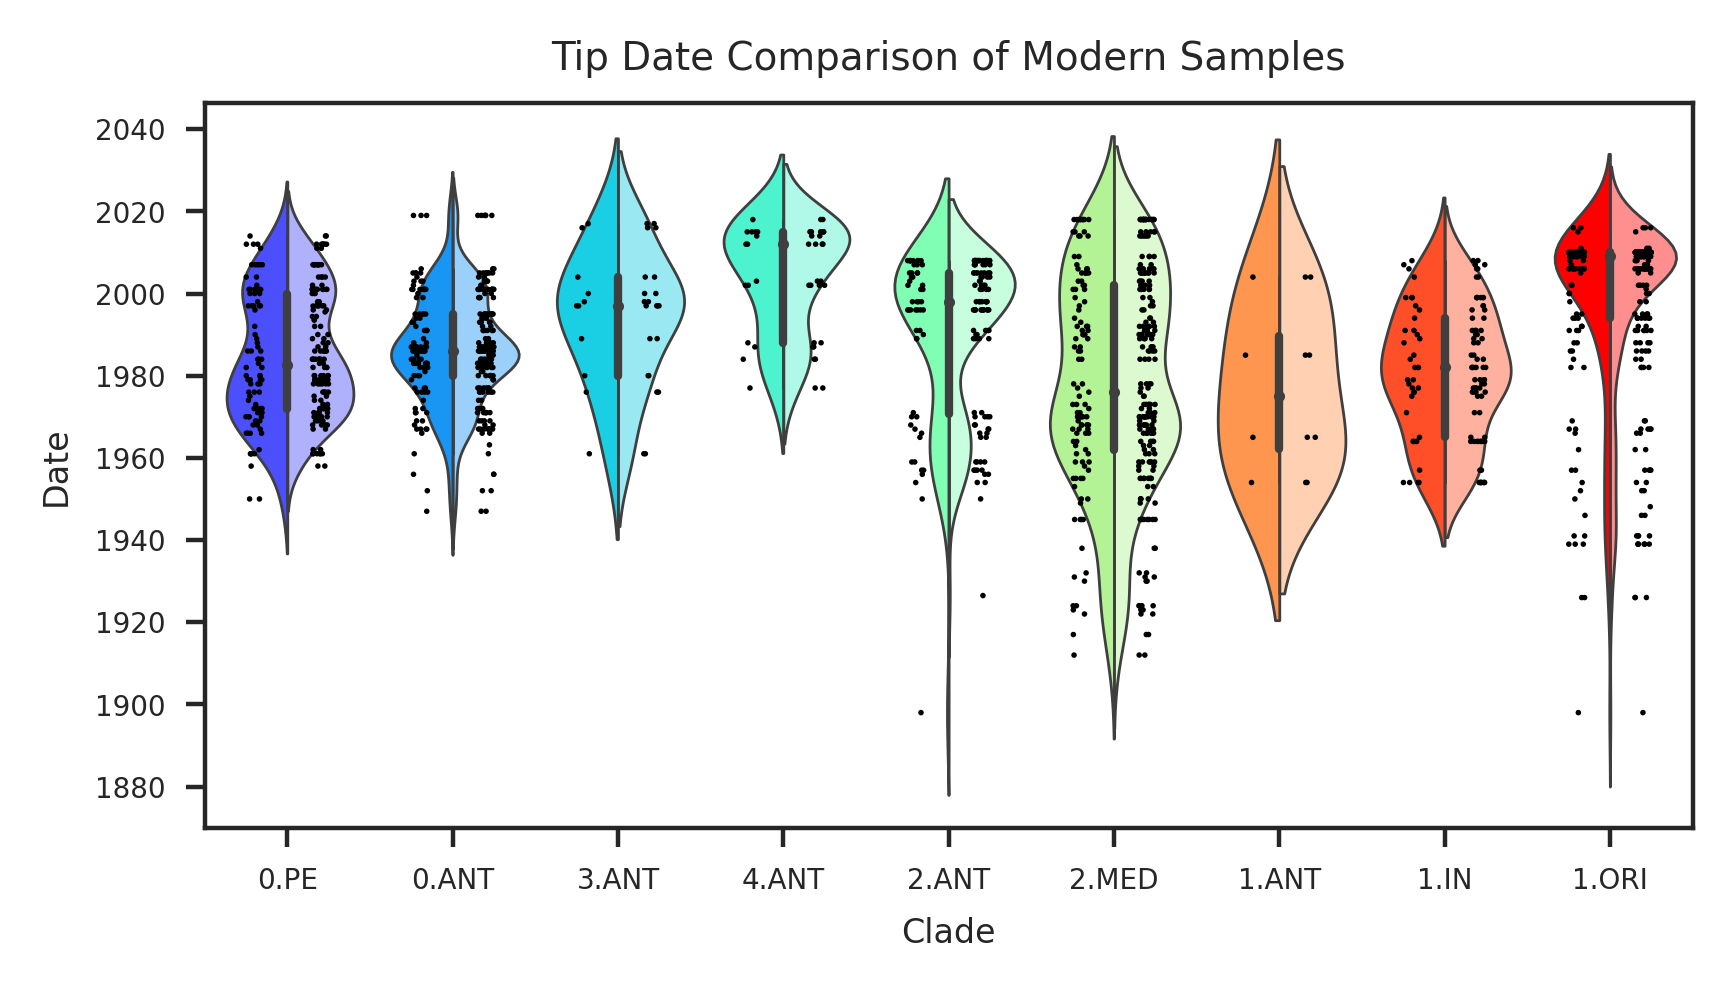

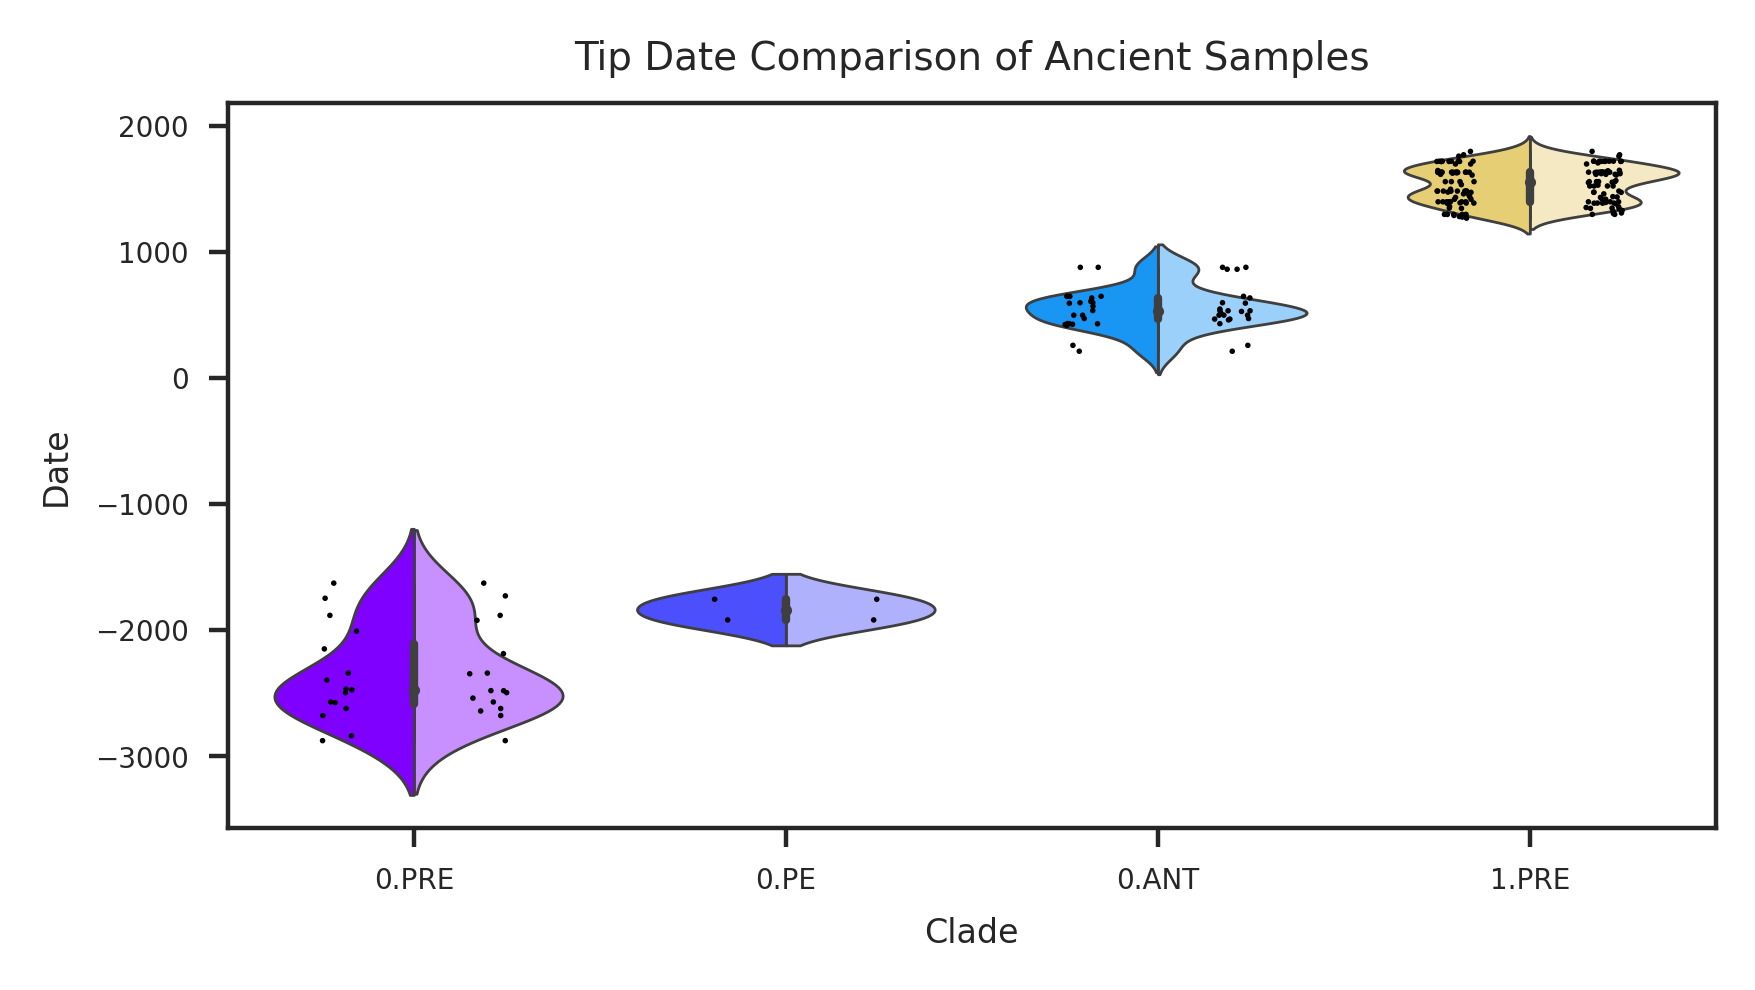

In [131]:
# Setup figure

flierprops = dict(marker='o', markersize=1)
ancient_clades = ["0.PRE1", "0.PRE2", "0.PE8", "0.ANT4", "1.PRE0", "1.PRE1", "1.PRE2", "1.PRE3"]

alpha_str = "70"
colors = list(colors_dict["branch_major"].values())
colors_split = []
for c in colors:
    colors_split.append(c)
    colors_split.append(c + alpha_str)
colors_modern = []
colors_modern_split = []
colors_ancient = []
colors_ancient_split = []


for c_minor in colors_dict["branch_minor"]:
    # Get associated branch_major color
    for c_major in colors_dict["branch_major"]:
        if c_major in c_minor:
            color = colors_dict["branch_major"][c_major]
    # Check for ancient
    if c_minor in ancient_clades and color not in colors_ancient:
        colors_ancient.append(color)
        colors_ancient_split.append(color)
        colors_ancient_split.append(color + alpha_str)        
    elif c_minor not in ancient_clades and color not in colors_modern:
        colors_modern.append(color)
        colors_modern_split.append(color)
        colors_modern_split.append(color + alpha_str)


date_df = date_df[(date_df["date_type"] == "Known Range") | (date_df["date_type"] == "Marginal Range")]

# -------------
# Modern
date_modern_df = copy.deepcopy(date_df)
for rec in date_modern_df.iterrows():
    if rec[1]["branch_minor"] in ancient_clades:
        date_modern_df.drop(rec[0], inplace=True)

fig, ax1 = plt.subplots(1, figsize=figsize_mini, dpi=400)
sns.violinplot(x="branch_major", y="date", hue="date_type", data=date_modern_df, linewidth=0.5, split=True)
sns.stripplot(x="branch_major", y="date", hue="date_type", data=date_modern_df, s=1, dodge=True, palette=["black", "black"])

ax1.set_xlabel("Clade", fontsize=6)
ax1.set_ylabel("Date", fontsize=6)
ax1.get_legend().remove()
ax1.set_title("Tip Date Comparison of Modern Samples", fontsize=7)

# Body Colors
i = 0
for art in ax1.get_children():
    # Violin Plots
    if isinstance(art, collections.PolyCollection):
        art.set_facecolor(colors_modern_split[i])
        i += 1
    # Box plots
    elif isinstance(art, patches.PathPatch):
        art.set_facecolor(colors_modern_split[i])
        i += 1
out_path = os.path.join(outdir, SCRIPT_NAME + "_tip-date-modern." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# ----------------------------
# Ancient
fig, ax1 = plt.subplots(1, figsize=figsize_mini, dpi=400)

date_ancient_df = copy.deepcopy(date_df)
for rec in date_ancient_df.iterrows():
    if rec[1]["branch_minor"] not in ancient_clades:
        date_ancient_df.drop(rec[0], inplace=True)
#display(date_ancient_df)

sns.violinplot(x="branch_major", y="date", hue="date_type", data=date_ancient_df, linewidth=0.5, split=True)
#sns.boxplot(x="branch_major", y="date", hue="date_type", data=date_modern_df, linewidth=0.5, dodge=True, showfliers=False)
sns.stripplot(x="branch_major", y="date", hue="date_type", data=date_ancient_df, s=1, dodge=True, palette=["black", "black"])

# Body Colors
i = 0
for art in ax1.get_children():
    # Violin Plots
    if isinstance(art, collections.PolyCollection):
        art.set_facecolor(colors_ancient_split[i])
        i += 1
    # Box plots
    elif isinstance(art, patches.PathPatch):
        art.set_facecolor(colors_ancient_split[i])
        i += 1
        
ax1.set_xlabel("Clade", fontsize=6)
ax1.set_ylabel("Date", fontsize=6)
ax1.get_legend().remove()
ax1.set_title("Tip Date Comparison of Ancient Samples", fontsize=7)

out_path = os.path.join(outdir, SCRIPT_NAME + "_tip-date-ancient." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## B. Clade MRCA Dates

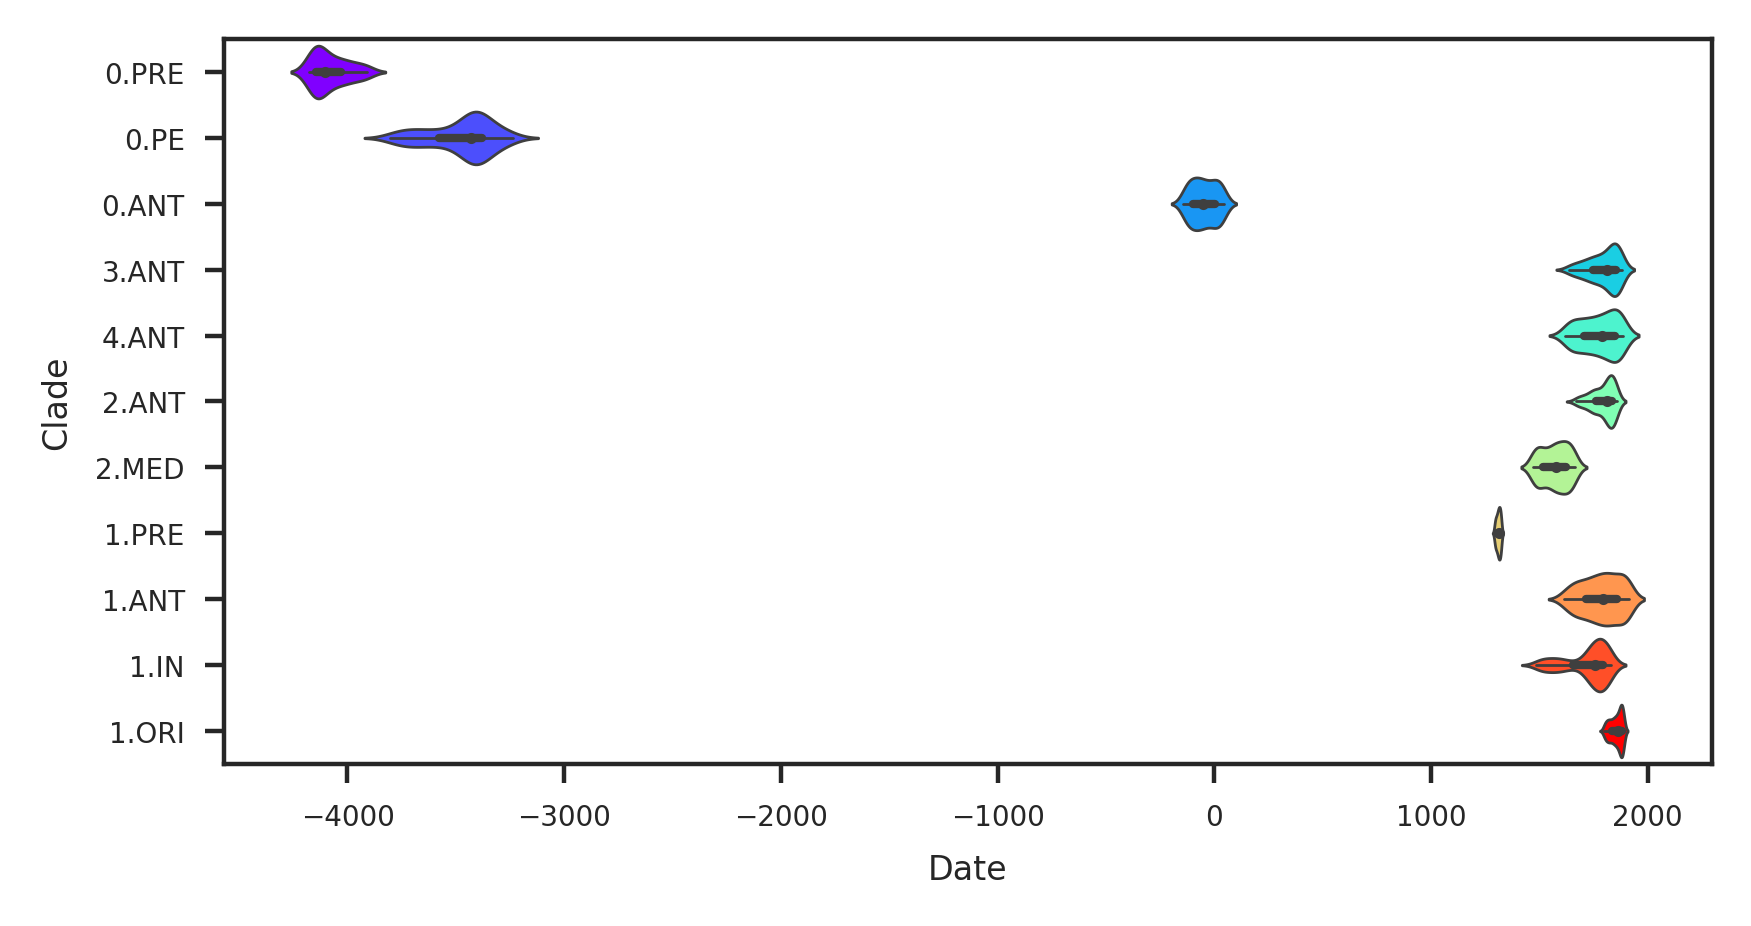

In [166]:
marginal_df = pd.DataFrame()

for branch_major in colors_dict["branch_major"]:
    branch_color =  colors_dict["branch_major"][branch_major]

    target_nodes = []
    for c in tt.tree.get_terminals(): 
        if tree_df["Branch_Major"][c.name] == branch_major:
            target_nodes.append(c)
    target_node = tt.tree.common_ancestor(target_nodes)
    
    # Calculate the x of the joint estimate
    joint_date = target_node.numdate
    
    # Calculate the x,y of the marginal distribution
    marg = target_node.marginal_pos_LH    
    marg_range = tt.get_max_posterior_region(target_node, fraction=1.0)
    marg_x = []
    
    for x in marg.x:
        x_date = tt.date2dist.to_numdate(x)
        if x_date >= marg_range[0] and x_date <= marg_range[1]:
            marg_x.append(x_date)

    
    df = pd.DataFrame({
        "date": [d for d in marg_x],       
        "date_type" : ["Marginal Distribution" for d in marg_x],
        "branch_major" : [branch_major for d in marg_x]
        
        })   

    marginal_df = marginal_df.append(df, ignore_index=True)
    
    # Get the x,y values associated with confidence range
    conf = tt.get_max_posterior_region(target_node, fraction=CONFIDENCE)
    conf_x = []
    
    for x in marg_x:
        if x >= conf[0] and x <= conf[1]:
            conf_x.append(x)

    df = pd.DataFrame({
        "date": [d for d in conf_x],       
        "date_type" : ["Marginal Density".format(int(CONFIDENCE * 100)) for d in conf_x],
        "branch_major" : [branch_major for d in conf_x]
        })   

    marginal_df = marginal_df.append(df, ignore_index=True)
    
#display(marginal_df)

fig, ax1 = plt.subplots(1, figsize=figsize_mini, dpi=dpi)

marginal_sub_df = marginal_df[
    (marginal_df["date_type"] == "Marginal Density") 
]

sns.violinplot(x="date", y="branch_major", data=marginal_sub_df, hue="date_type", linewidth=0.5, split=False, ax=ax1)

# Body Colors
i = 0
for art in ax1.get_children():
    if i >= len(colors): i = 0
    # Violin Plots
    if isinstance(art, collections.PolyCollection):
        art.set_facecolor(colors[i])
        i += 1
    # Box plots
    elif isinstance(art, patches.PathPatch):
        art.set_facecolor(colors[i])
        i += 1

ax1.get_legend().remove()
ax1.set_xlabel("Date", fontsize=6)
ax1.set_ylabel("Clade", fontsize=6)
#ax1.set_title("MRCA Date of the Major Clades", fontsize=7)
out_path = os.path.join(outdir, SCRIPT_NAME + "_clade-mrca-date." + FMT)
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## C. Historical Node Estimates

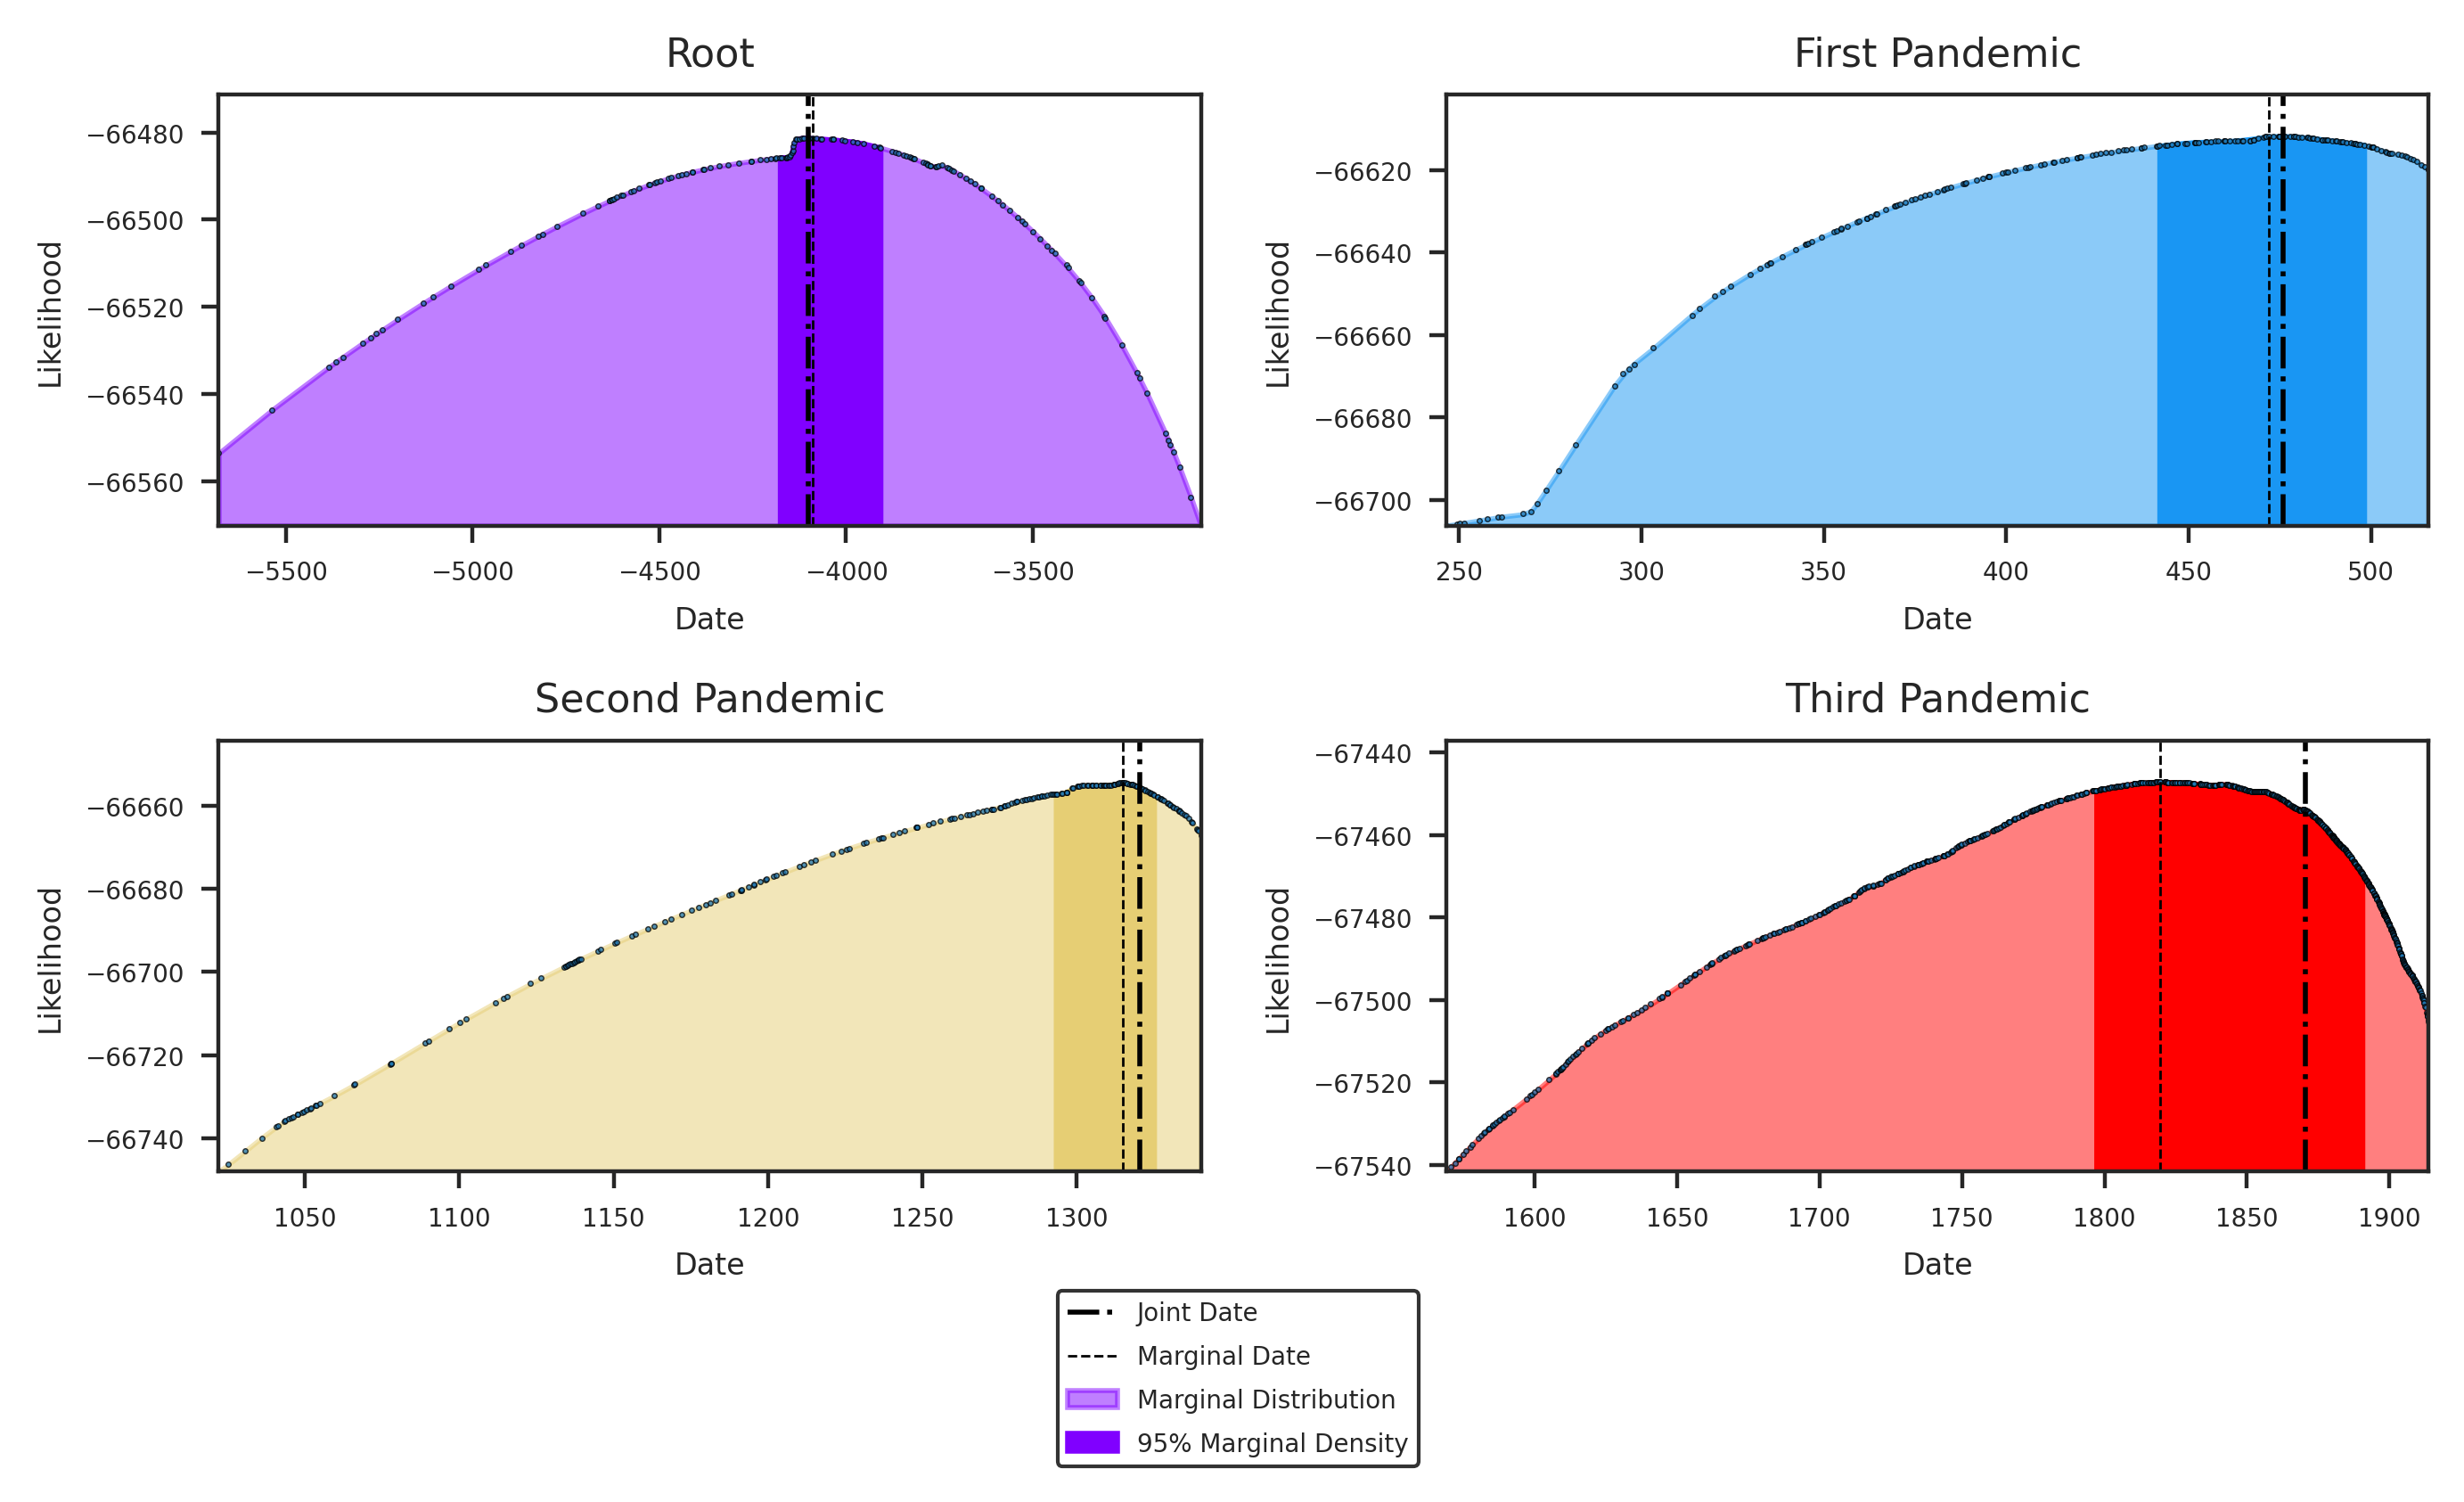

In [163]:
marg_dict = {
    0 : {
        'label' : 'Root',
        'target_branches' : ["0.PRE", "1.ORI"],
        'axes' : [0,0],
        'xbuf' : 100,
        'ybuf' : 10,
        'exclude_nodes': [],
        'color' : colors_dict["branch_major"]["0.PRE"],
    },
    1 : {
        'label' : 'First Pandemic',
        'target_branches' : ["0.ANT4",],
        'axes' : [0,1],       
        'xbuf' : 10, 
        'ybuf' : 10,      
        'exclude_nodes': ['SAMEA1061800'],        
        'color' : colors_dict["branch_major"]["0.ANT"],        
    },        
    2 : {
        'label' : 'Second Pandemic',
        'target_branches' : ["1.PRE",],
        'axes' : [1,0],       
        'xbuf' : 10, 
        'ybuf' : 10,    
        'exclude_nodes': [],       
        'color' : colors_dict["branch_major"]["1.PRE"],        
    },   
    3 : {
        'label' : 'Third Pandemic',
        'target_branches' : ["1.ORI",],
        'axes' : [1,0],       
        'xbuf' : 10, 
        'ybuf' : 10,
        'exclude_nodes': [],  
        'color' : colors_dict["branch_major"]["1.ORI"],        
    },      
}

fig_marg = plt.figure(figsize=(8,4), dpi=dpi)
gs = gridspec.GridSpec(2, 2, figure=fig_marg, wspace=0.25, hspace=0.5)

axes = []
axes += [fig_marg.add_subplot(gs[0, 0])]
axes += [fig_marg.add_subplot(gs[0, 1])]
axes += [fig_marg.add_subplot(gs[1, 0])]
axes += [fig_marg.add_subplot(gs[1, 1])]

  
for ax_i in marg_dict:    
    # Get the target node
    target_branches = marg_dict[ax_i]["target_branches"]
    target_nodes = []
    target_node = None
    for c in tt.tree.get_terminals():
        if c.name in marg_dict[ax_i]["exclude_nodes"]: continue
        branch = tree_df["Branch_Major"][c.name]
        subbranch = tree_df["Branch_Minor"][c.name]
        if branch in target_branches or subbranch in target_branches :
            target_nodes.append(c)
    target_node = tt.tree.common_ancestor(target_nodes)
    
    # Calculate the x of the joint estimate
    joint_date = target_node.numdate
    
    # Calculate the x,y of the marginal distribution
    marg = target_node.marginal_pos_LH    
    marg_range = tt.get_max_posterior_region(target_node, fraction=1.0)
    marg_x, marg_y = [], []
    
    for x,y in zip(marg.x, marg.y):
        x_date = tt.date2dist.to_numdate(x)
        if x_date >= marg_range[0] and x_date <= marg_range[1]:
            marg_x.append(x_date)
            marg_y.append(-y)

    marg_peak = tt.date2dist.to_numdate(marg.peak_pos)

    # Reverse coordinates for Spline function
    marg_x.reverse()
    marg_y.reverse()
    marg_s = UnivariateSpline(marg_x, marg_y, s=1)
    marg_ys = marg_s(marg_x)
    
    # Get the x,y values associated with confidence range
    conf = tt.get_max_posterior_region(target_node, fraction=CONFIDENCE)
    conf_x = []
    conf_y = []
    
    for x,y in zip(marg_x, marg_y):
        if x >= conf[0] and x <= conf[1]:
            conf_x.append(x)
            conf_y.append(y) 

    # Fit a spline to the confidence range
    conf_s = UnivariateSpline(conf_x, conf_y, s=1)
    conf_ys = conf_s(conf_x)    
    

    # Labels
    axes[ax_i].set_title(marg_dict[ax_i]["label"], fontsize=8)
    axes[ax_i].set_xlabel("Date", fontsize=6)
    axes[ax_i].set_ylabel("Likelihood", fontsize=6)
    
    # Plot Points
    axes[ax_i].scatter(x=marg_x, y=marg_y, ec="black", alpha=0.75, s=1, fc="#1F77B4", zorder=2, lw=0.25)
    # Draw Fills
    axes[ax_i].fill_between(marg_x, marg_ys, min(marg_y), zorder=1, color=marg_dict[ax_i]["color"], alpha=0.5)
    axes[ax_i].fill_between(conf_x, conf_ys, min(marg_y), zorder=1, color=marg_dict[ax_i]["color"], alpha=1.0)
    
    # Draw Peak Line
    axes[ax_i].axvline(x=marg_peak, color="black", linestyle="--", lw=0.5)
    axes[ax_i].axvline(x=joint_date, color="black", linestyle="-.", lw=1)    

    # Limits
    axes[ax_i].set_xlim(min(marg_x),max(marg_x))
    axes[ax_i].set_ylim(min(marg_y),max(marg_y) + marg_dict[ax_i]['ybuf'])
    

#fig_marg.suptitle("Node Dating Estimates")

# Add manual legend elements
axes[ax_i].fill_between([CURRENT_YEAR + 1], [0], [1], zorder=1, color=colors_dict["branch_major"]["0.PRE"], alpha=0.50, label="Marginal Distribution")
axes[ax_i].fill_between([CURRENT_YEAR + 1], [0], [1], zorder=1, color=colors_dict["branch_major"]["0.PRE"], alpha=1.0, label="{}% Marginal Density".format(int(CONFIDENCE * 100)))
axes[ax_i].axvline(x=CURRENT_YEAR + 1, linestyle="-.", color="black", lw=1, label="Joint Date",)
axes[ax_i].axvline(x=CURRENT_YEAR + 1, linestyle="--", color="black", lw=0.5, label="Marginal Date",)
leg = fig_marg.legend(frameon=True, edgecolor="black", 
                      #bbox_to_anchor=(1.05, 0.89),
                     bbox_to_anchor=(0.55, 0.05)
                     )
leg.get_frame().set_linewidth(0.75)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_node-dating." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

# 3. Plot Timetree: Phylo

In [157]:
# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

263312.53	--ClockTree.branch_length_to_years: setting node positions in units of
         	  years


In [167]:
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    CONF_BAD_RANGE = 10000
    CONF_EXTREME = 100000

    bad_conf = [["node", "lower_bad", "upper_bad", "lower_corrected", "upper_corrected"]]
    for c in tt_copy.tree.find_clades():
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        
        # Check if marginal doesn't contain joint date
        if c.numdate < (conf[0] - 10) or c.numdate > (conf[1] + 10):
            print(c.name, "\t", conf[0], "\t", c.numdate, "\t", conf[1])
            
            
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE or conf[0] < -CONF_EXTREME or conf[1] > CONF_EXTREME:
            print("Bad confidence estimated for:", c.name,"\t", conf_range, "\t", conf[0], "\t", conf[1], "\tSetting to", c.numdate)       
            tree_df.at[c.name, "timetree_num_date_bar"] = [c.numdate, c.numdate]
            bad_conf.append([c.name, conf[0], conf[1], c.numdate, c.numdate])

    out_path_bad_conf = os.path.join(outdir, SCRIPT_NAME + "_bad-confidence.tsv")
    with open(out_path_bad_conf, "w") as outfile:
        for node in bad_conf:
            outfile.write("\t".join([str(n) for n in node]) + "\n")

SAMEA3541827 	 -2875.991780821918 	 -2887.8181309167103 	 -2676.991780821918
NODE175 	 1955.7382233887386 	 1980.9169744422654 	 1963.95369482739
NODE455 	 740.5368684788127 	 1953.8378193131075 	 752.0085816643857


## Setup Up Figure and Axes

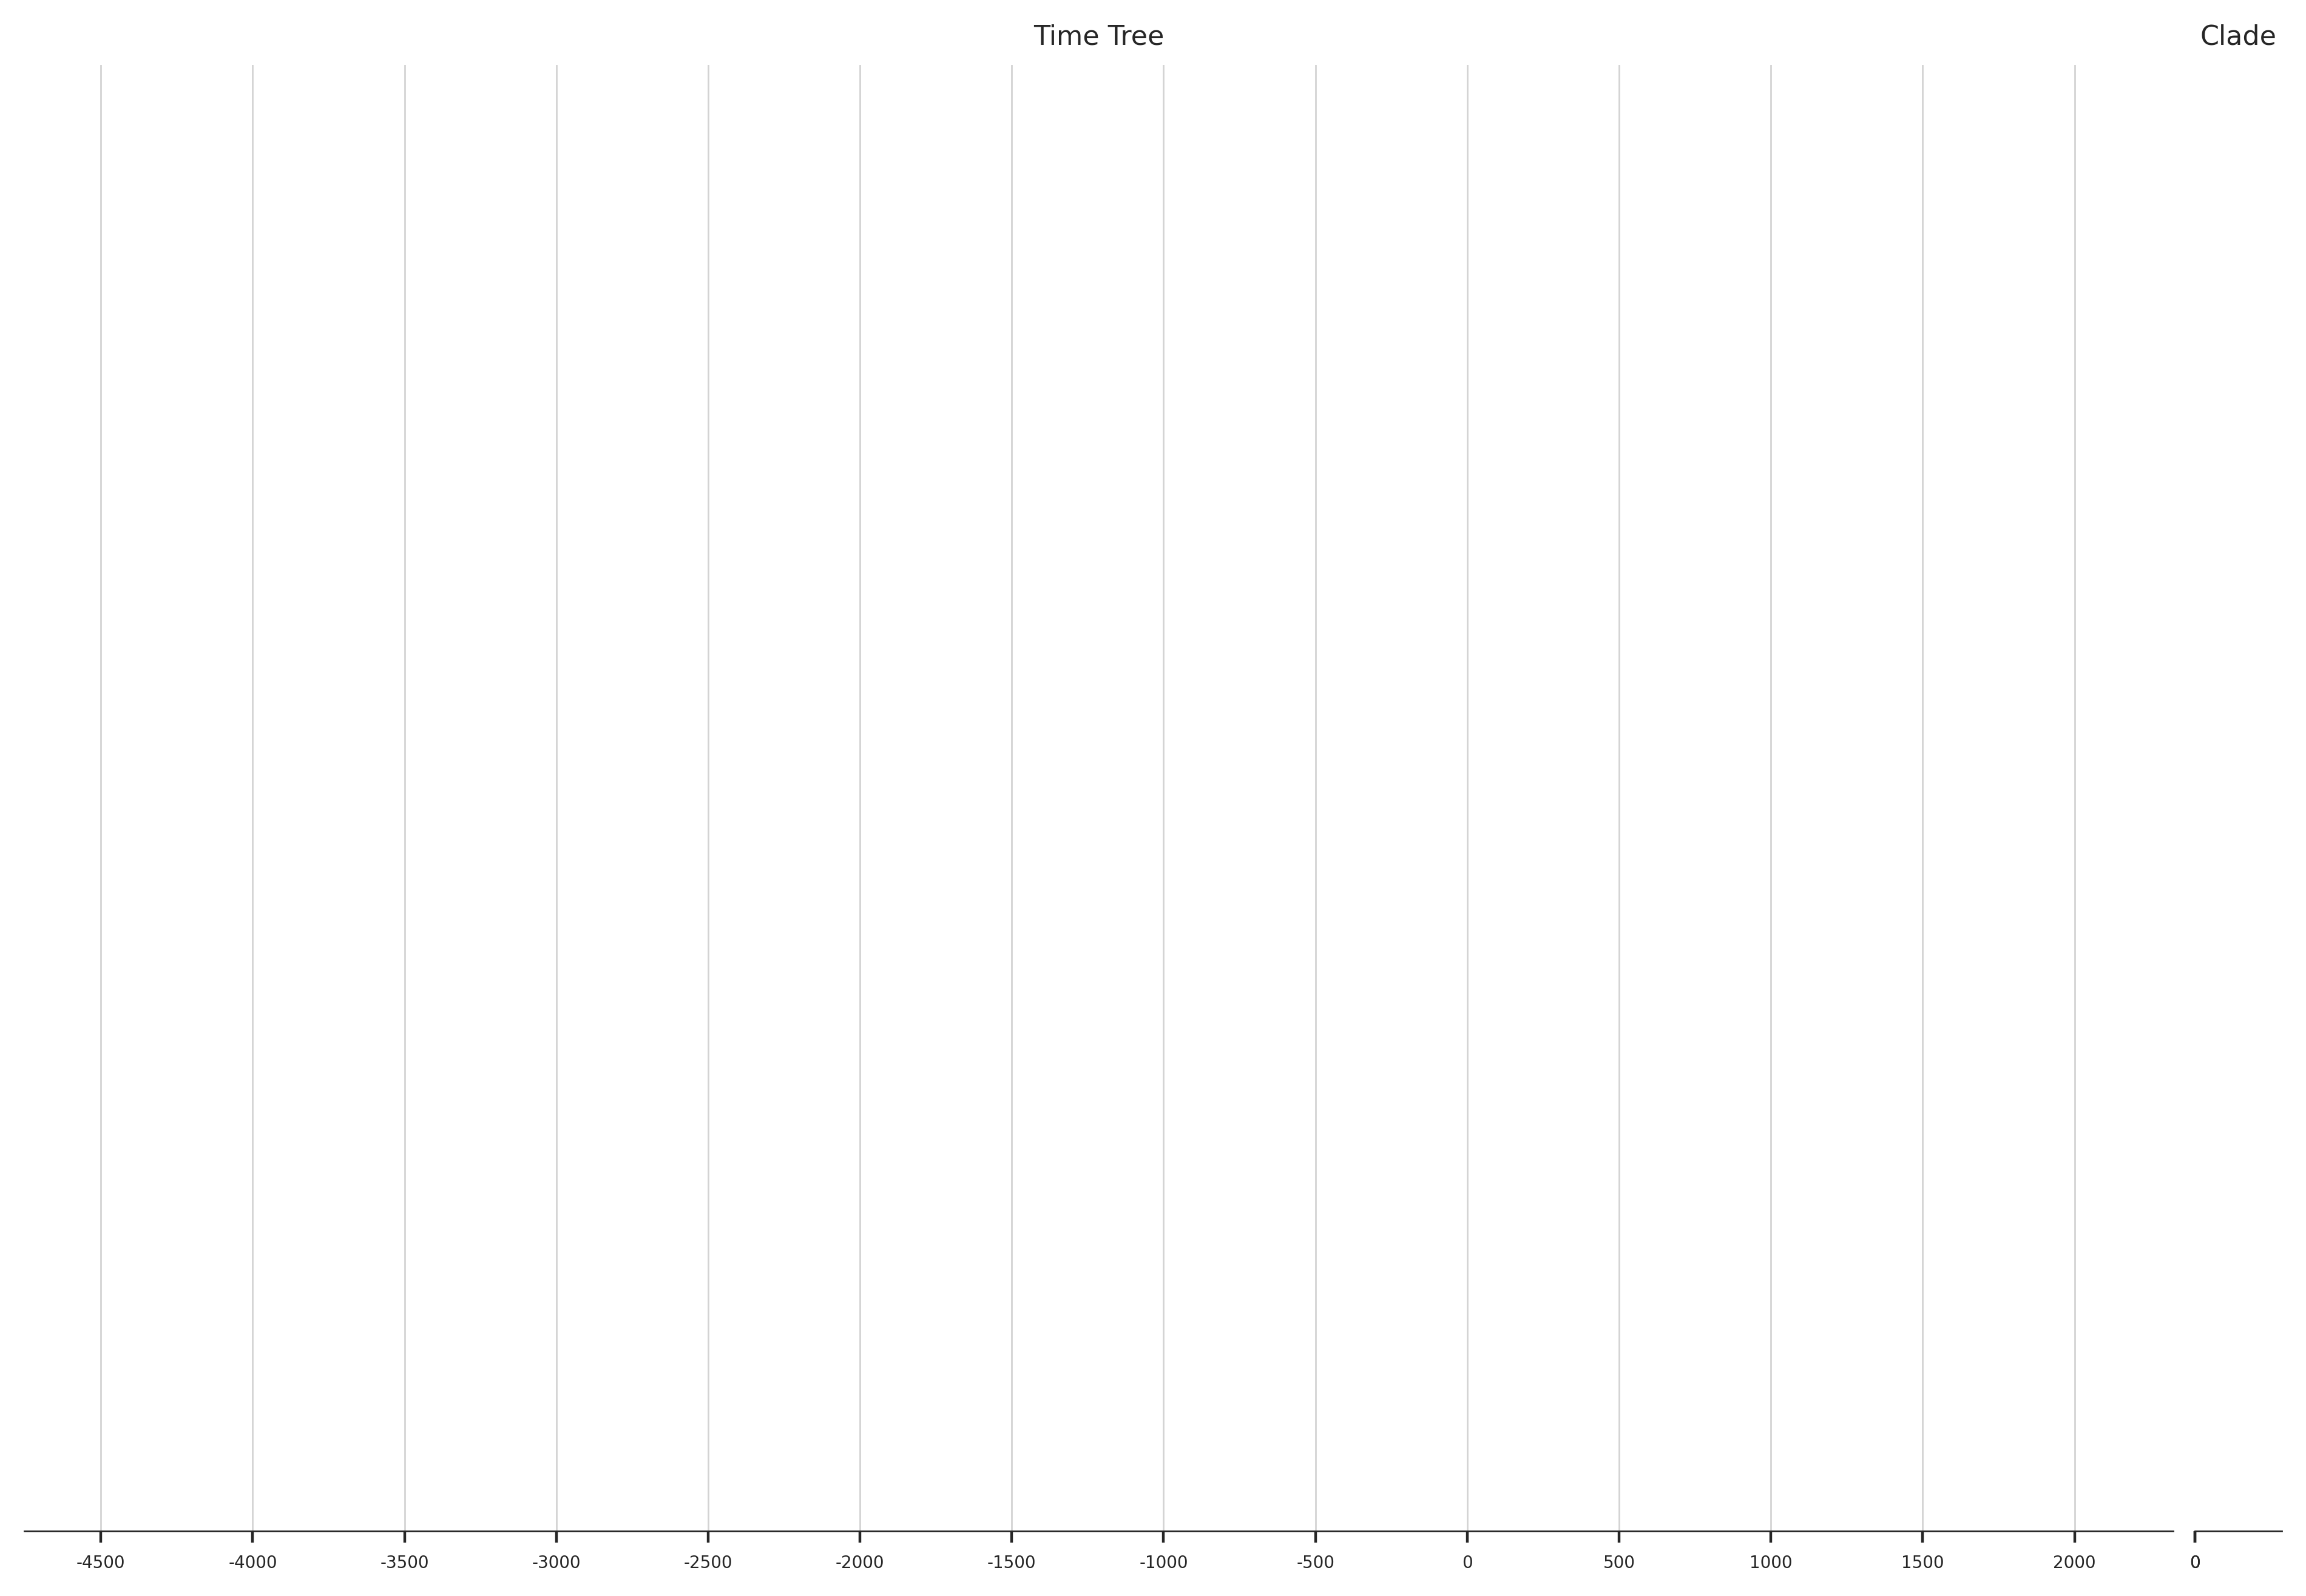

In [168]:
axes_dict = {
    "Tree" : {
        "prop" : 20,
        "title" : "Time Tree",
        "xlabel" : "Year",
        "key" : "Tree",
        "i" : 0,
        "xmax"   : 0,       
    },
    "Clade" : {
        "prop" : 1,
        "title" : "Clade",
        "xlabel" : "",        
        "key" : "Clade",
        "i" : 1,  
        "xmax"   : 0,        
    },   
}

fig_timetree = plt.figure(figsize=(12,8), dpi=dpi)

total_col = sum([axes_dict[ax]["prop"] for ax in axes_dict])
gs = gridspec.GridSpec(1, total_col, figure=fig_timetree, wspace=0.25, hspace=0)

axes = []
i_ax = 0
i_prev = 0
for ax in axes_dict:
    i_cur = i_prev + axes_dict[ax]["prop"]
    if len(axes) > 0:
        axes += [fig_timetree.add_subplot(gs[0, i_prev:i_cur], sharey=axes[0])]
    else:
        axes += [fig_timetree.add_subplot(gs[0, i_prev:i_cur],)]
    i_prev = i_cur
    axes[i_ax].set_title(axes_dict[ax]["title"], fontsize=8)
    
    # Spines
    for s in axes[i_ax].spines:
        axes[i_ax].spines[s].set_linewidth(0.5)
    axes[i_ax].spines["right"].set_visible(False)
    axes[i_ax].spines["top"].set_visible(False)
    axes[i_ax].spines["left"].set_visible(False)  
    
    # X-Axis
    if i_ax != 0:
        axes[i_ax].set_xticks([0, axes_dict[ax]["xmax"]])
        axes[i_ax].set_xticklabels([""] + [str(axes_dict[ax]["xmax"])])
        axes[i_ax].set_xlabel(axes_dict[ax]["xlabel"], fontsize=6)
    # Y-Axis
    axes[i_ax].set_yticks([])
        
    i_ax += 1
    
ax_tree = axes[0]
ax_clade = axes[1]

# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
ax_tree.set_xticks(ticks_dict["tick_locs"])
ax_tree.set_xticklabels(ticks_dict["tick_labels"])
date_to_x = float(ticks_dict["tick_locs"][-1]) - float(ticks_dict["tick_labels"][-1])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax_tree.axvline(x=loc, color="darkgrey", alpha=0.5, lw=0.50)

# --------------------------------------------
# Limits
x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

x_min = 0
ax_tree.set_xlim(x_min - x_buffer - x_buffer, ticks_dict["tick_locs"][-1] + x_buffer)
ax_tree.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax_tree.spines["right"].set_visible(False)
ax_tree.spines["top"].set_visible(False)
ax_tree.spines["left"].set_visible(False)

## Add Clade Colors

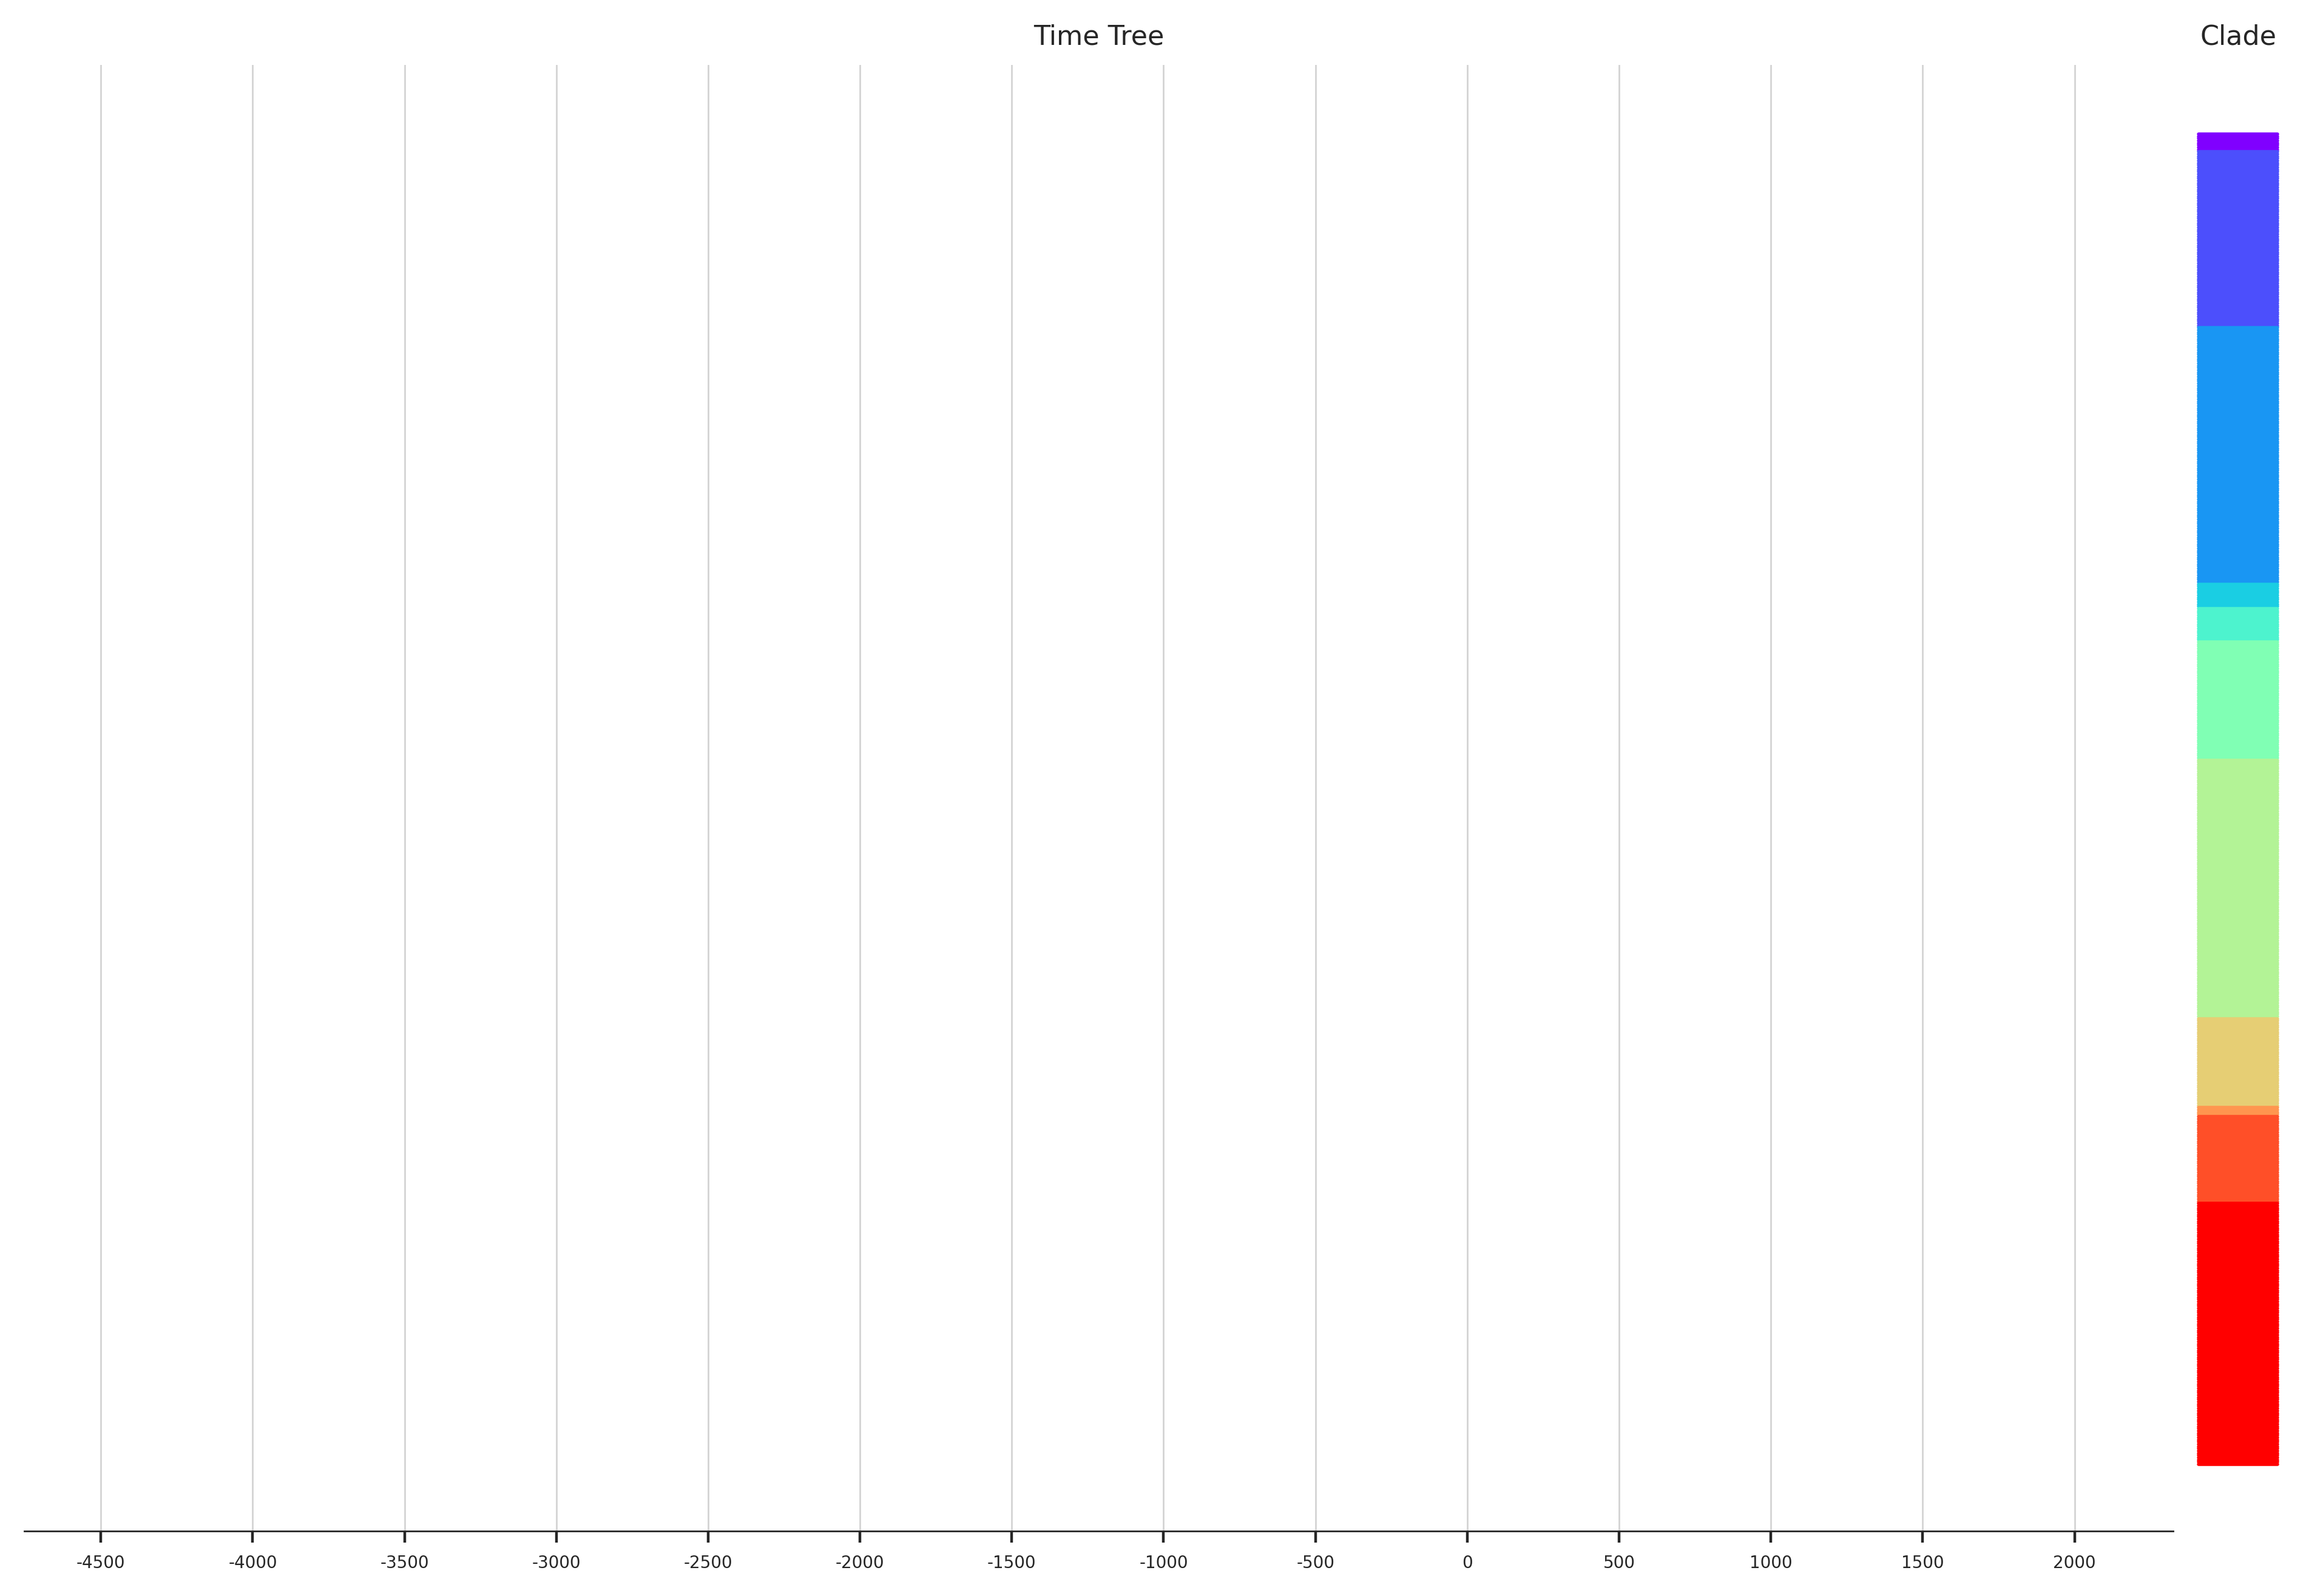

In [169]:
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#axes[0].scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")

for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1]["Branch_Major"]
    color = colors_dict["branch_major"][state]
    ax_clade.plot([0, 1], [y,y], alpha=1, c=color, linewidth=1)

ax_clade.set_xticks([])
ax_clade.spines["bottom"].set_visible(False) 

fig_timetree

## Add Legend

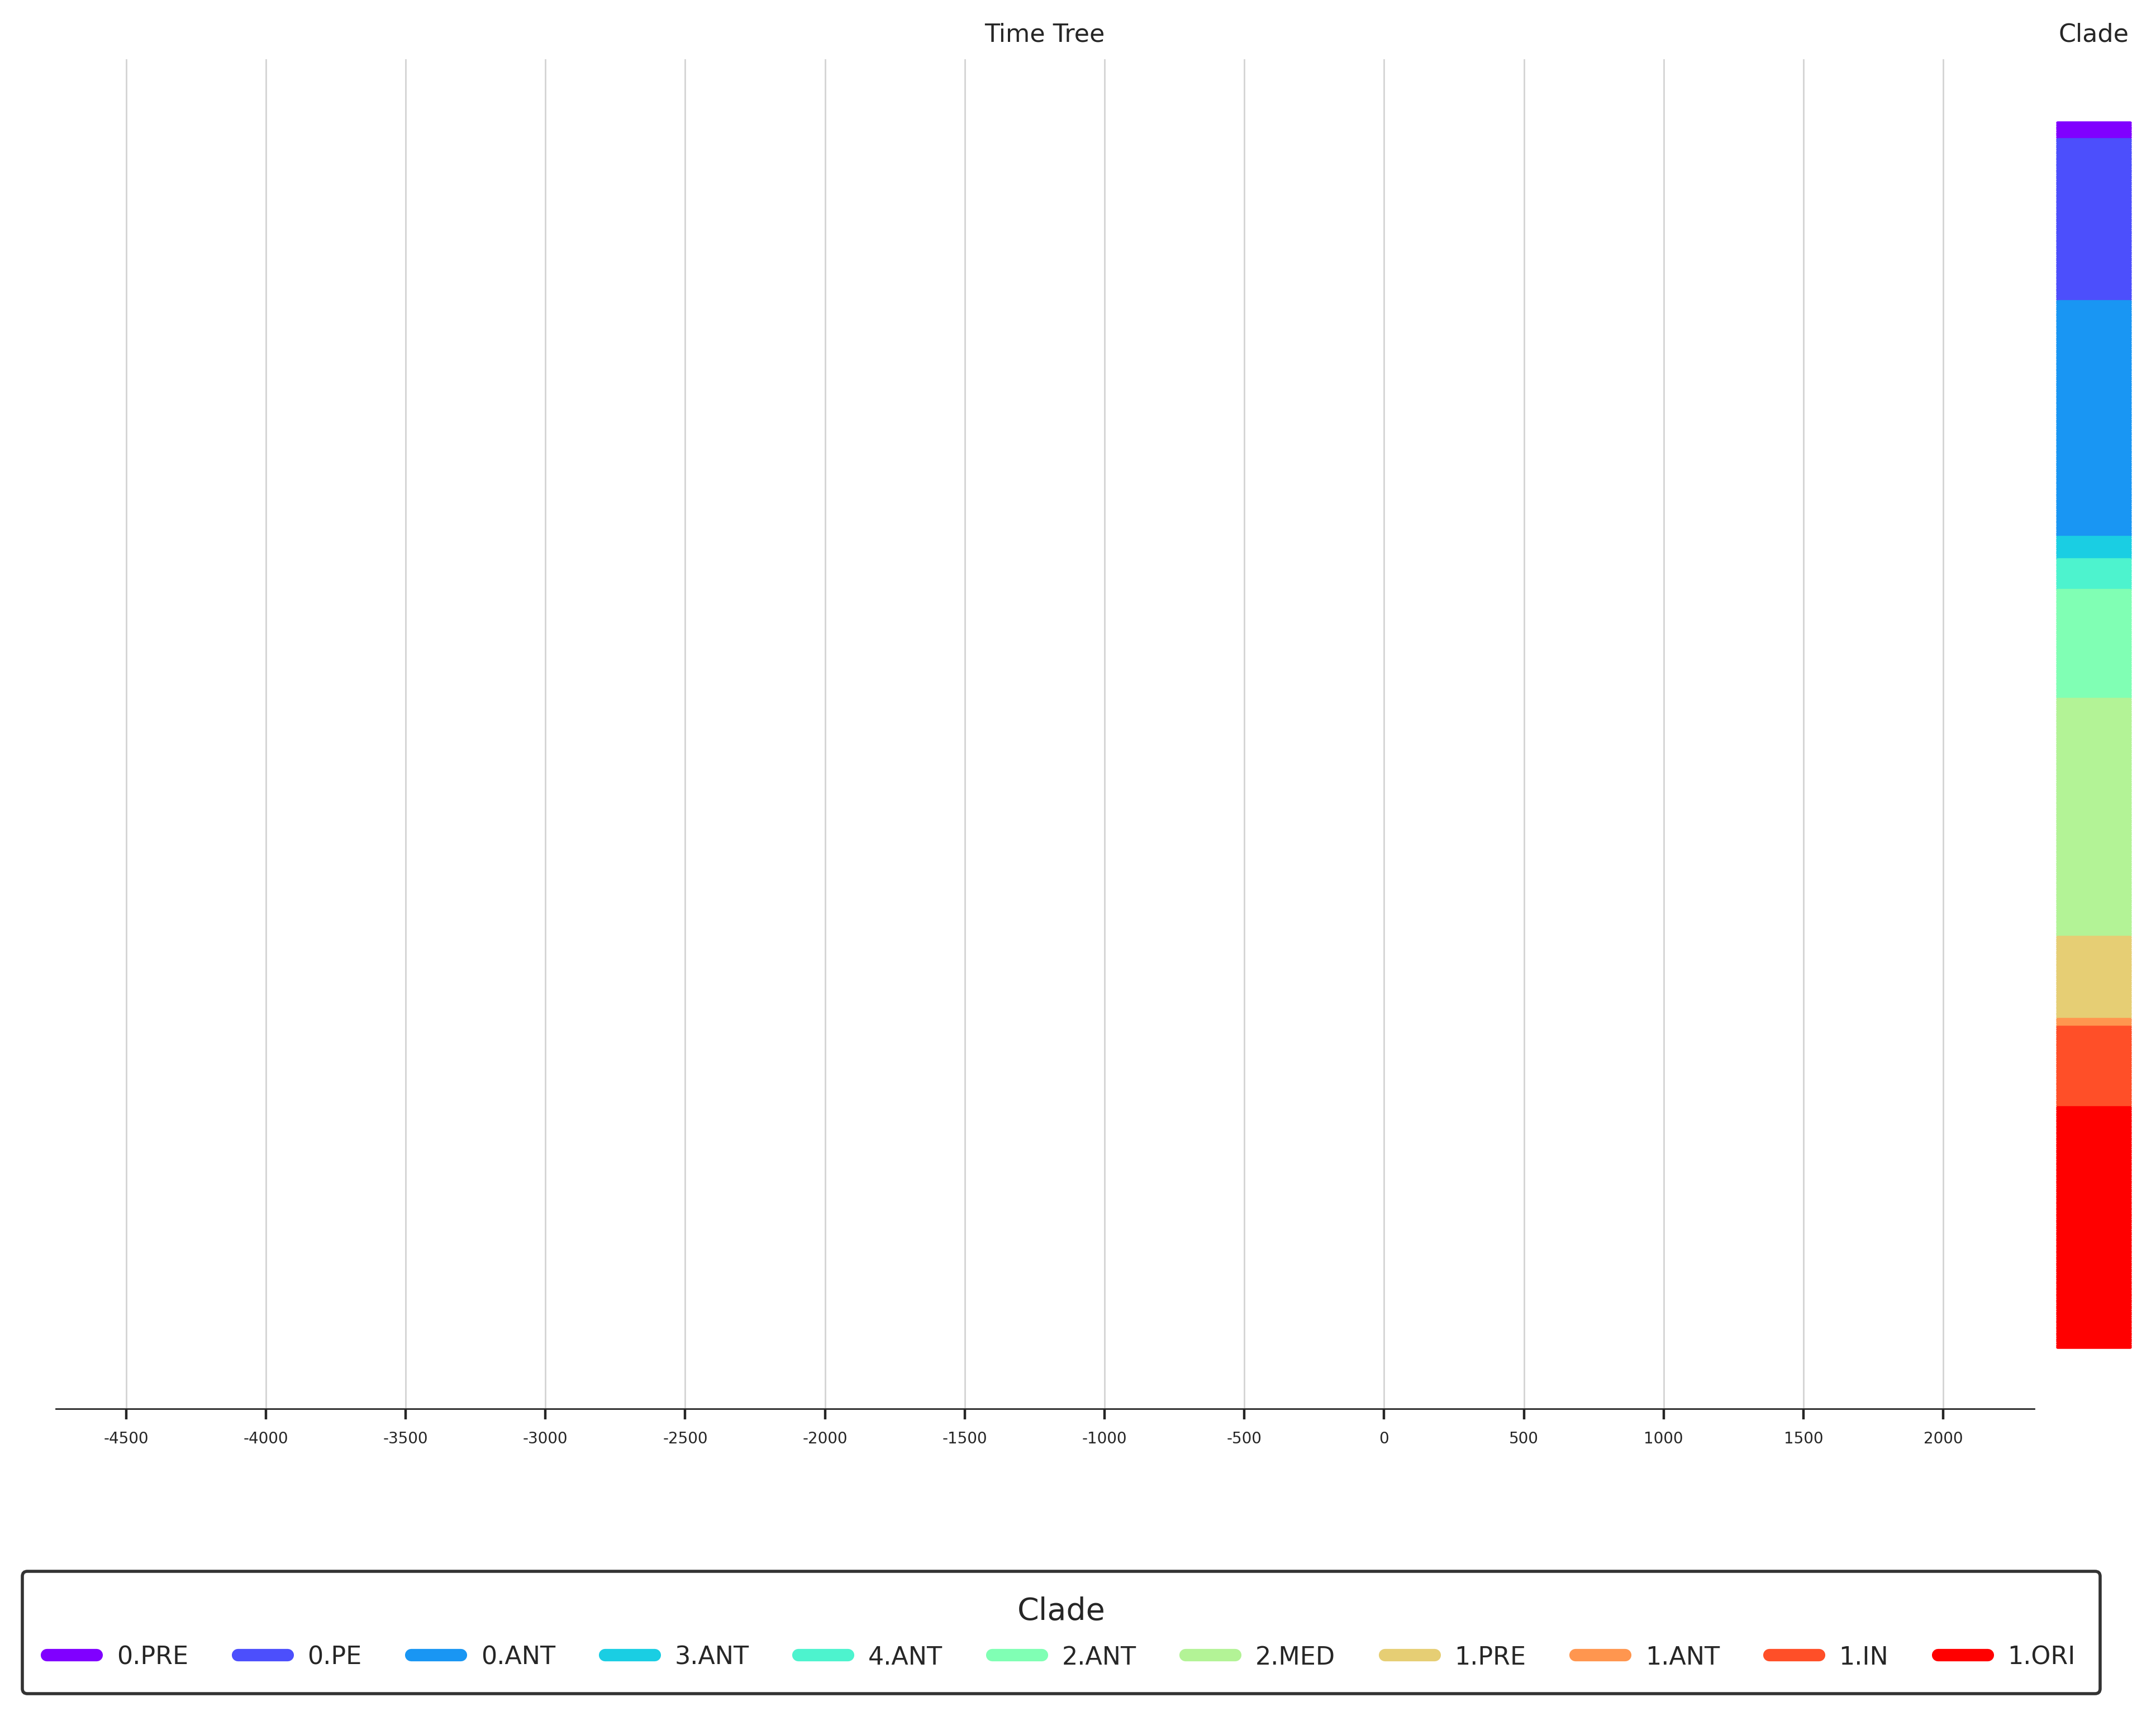

In [170]:
clade_lines = [lines.Line2D([0], [0], color=colors_dict["branch_major"][state], lw=4) 
                for state in colors_dict["branch_major"]]
clade_labels = [state for state in colors_dict["branch_major"]]

clade_legend = fig_timetree.legend(clade_lines, 
           clade_labels,
           ncol=len(clade_labels),
           loc="center", 
           bbox_to_anchor=(0.5, 0),
           #bbox_to_anchor=(0.14,-0.13),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Clade",
           title_fontsize=10,
           fontsize=8,
          )

fig_timetree

## Add Confidence Bars

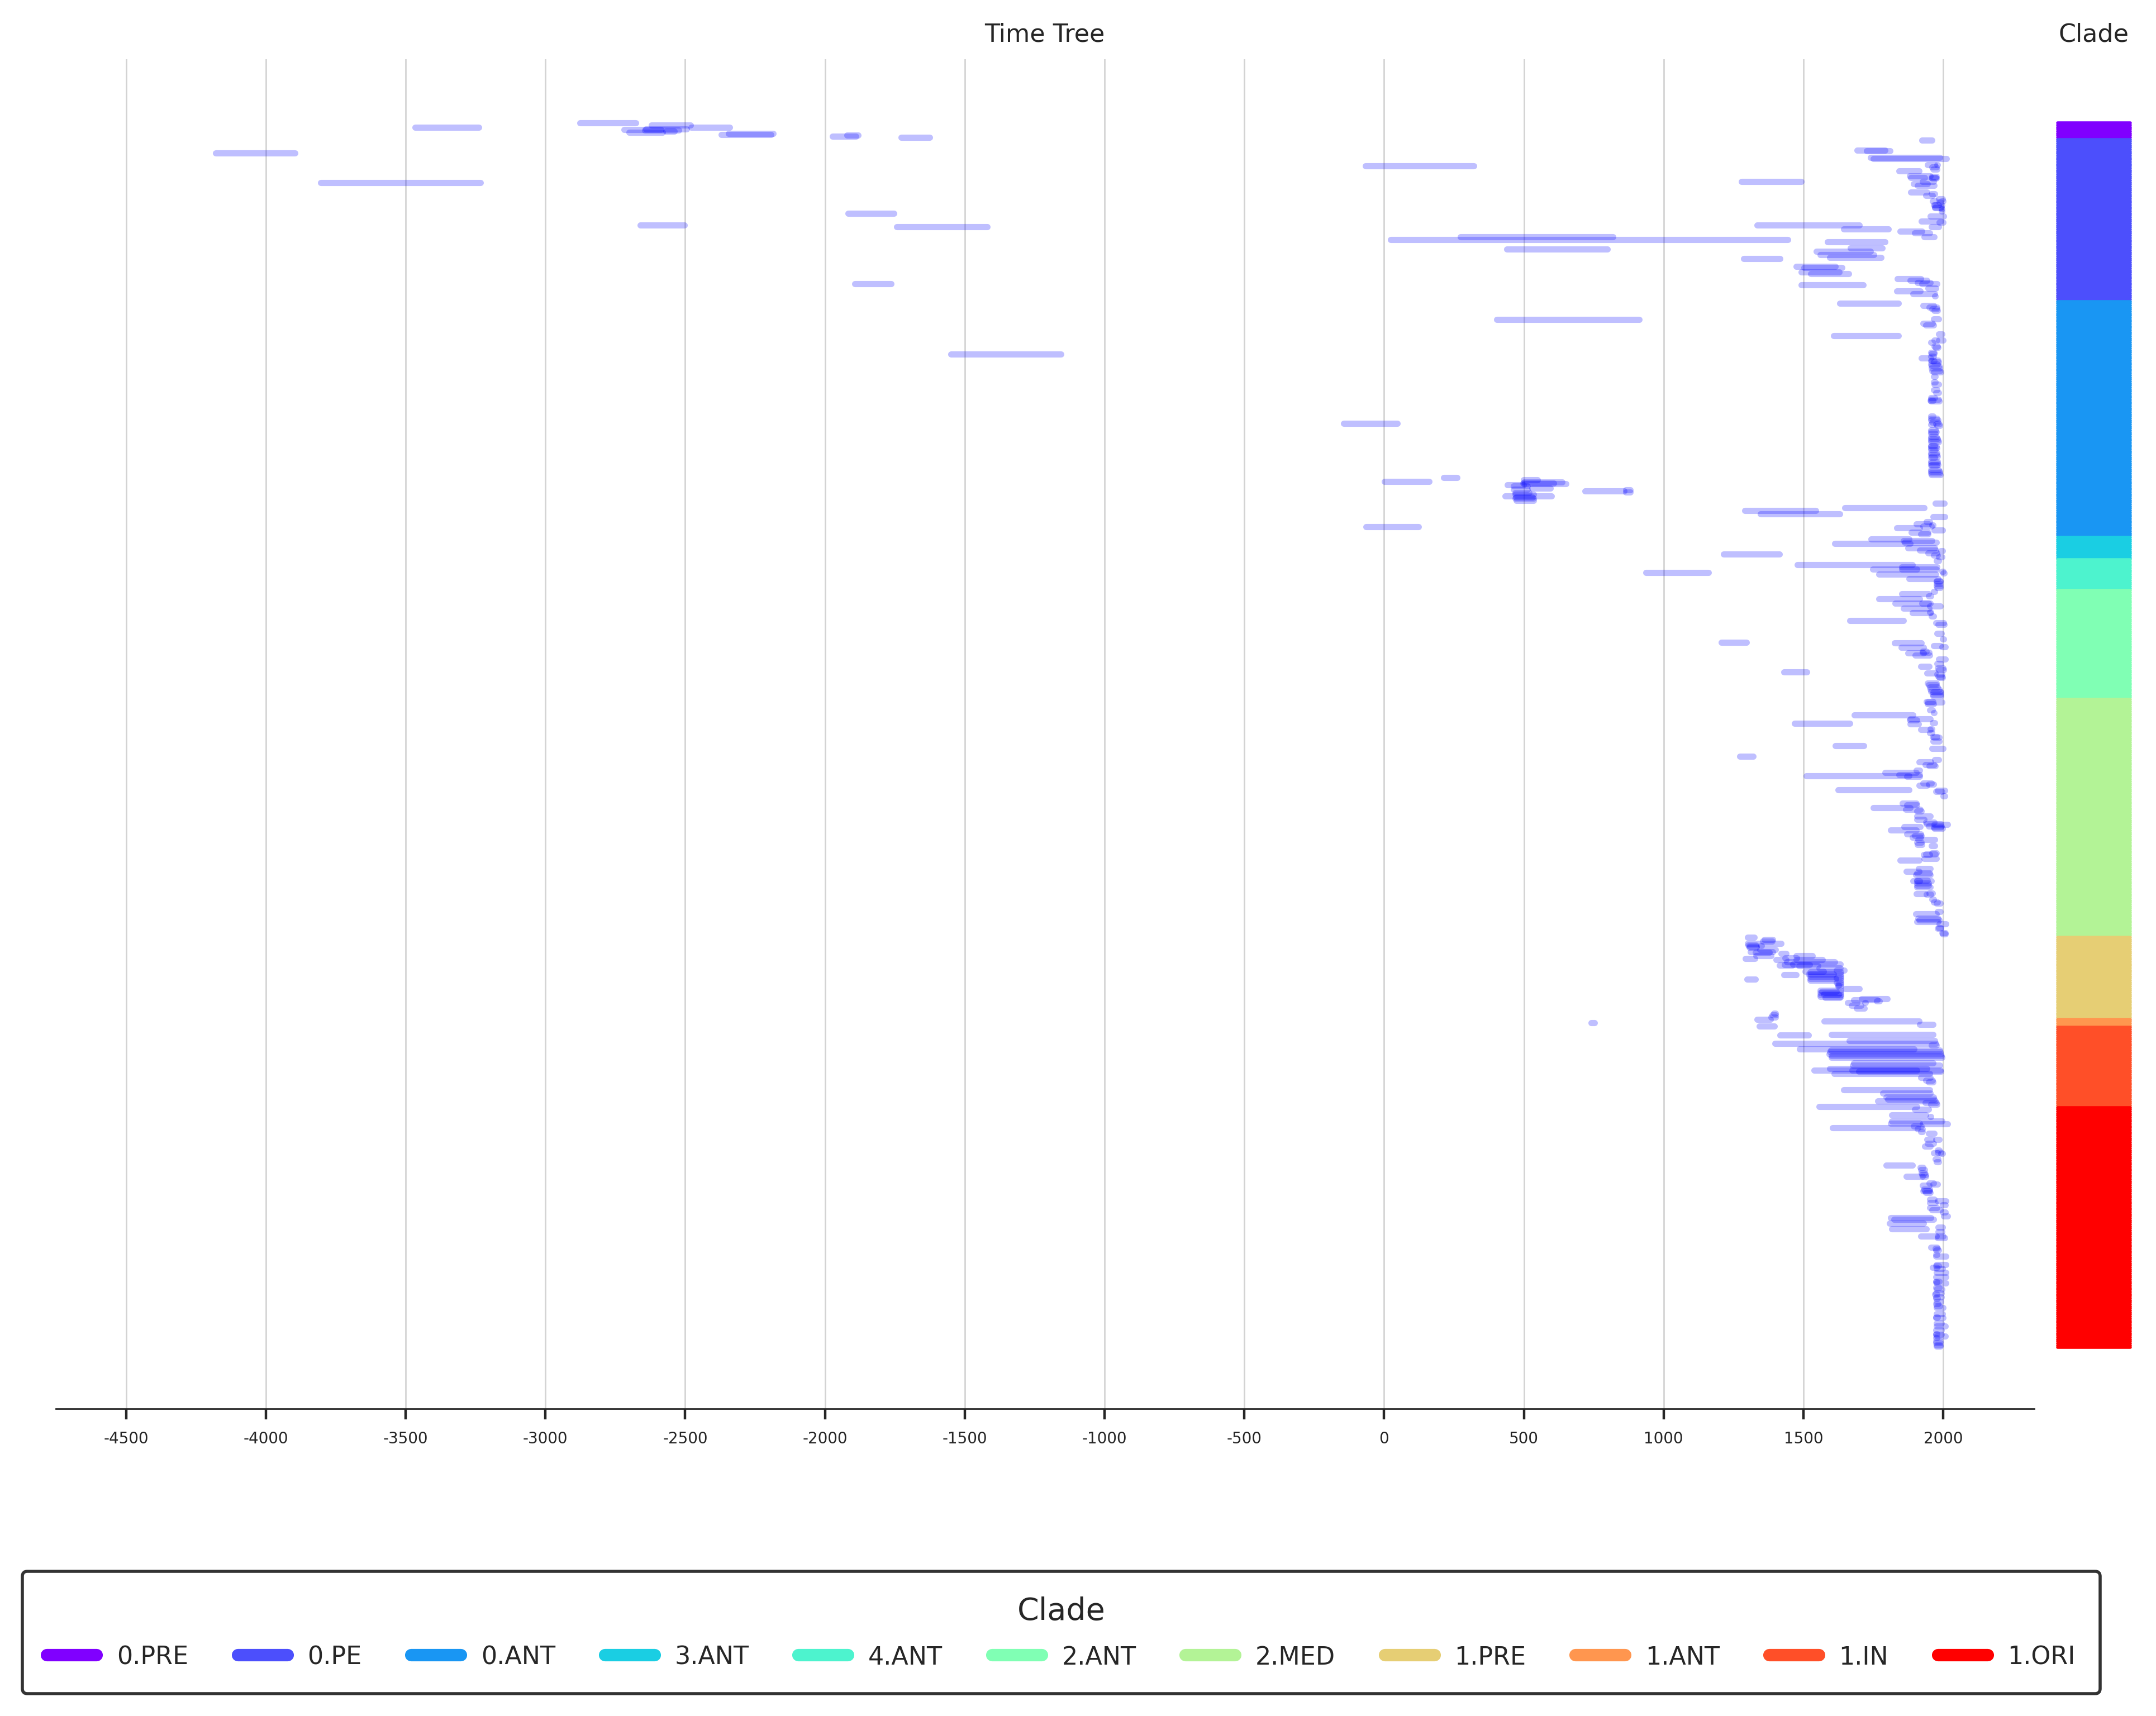

In [171]:
# --------------------------------------------
# Confidence Bars
x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax_tree.plot([bar_lower, bar_upper], [y,y], alpha=0.25, c="blue", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower
            
fig_timetree

## Add Phylogeny

264207.50	--ClockTree.branch_length_to_years: setting node positions in units of
         	  years


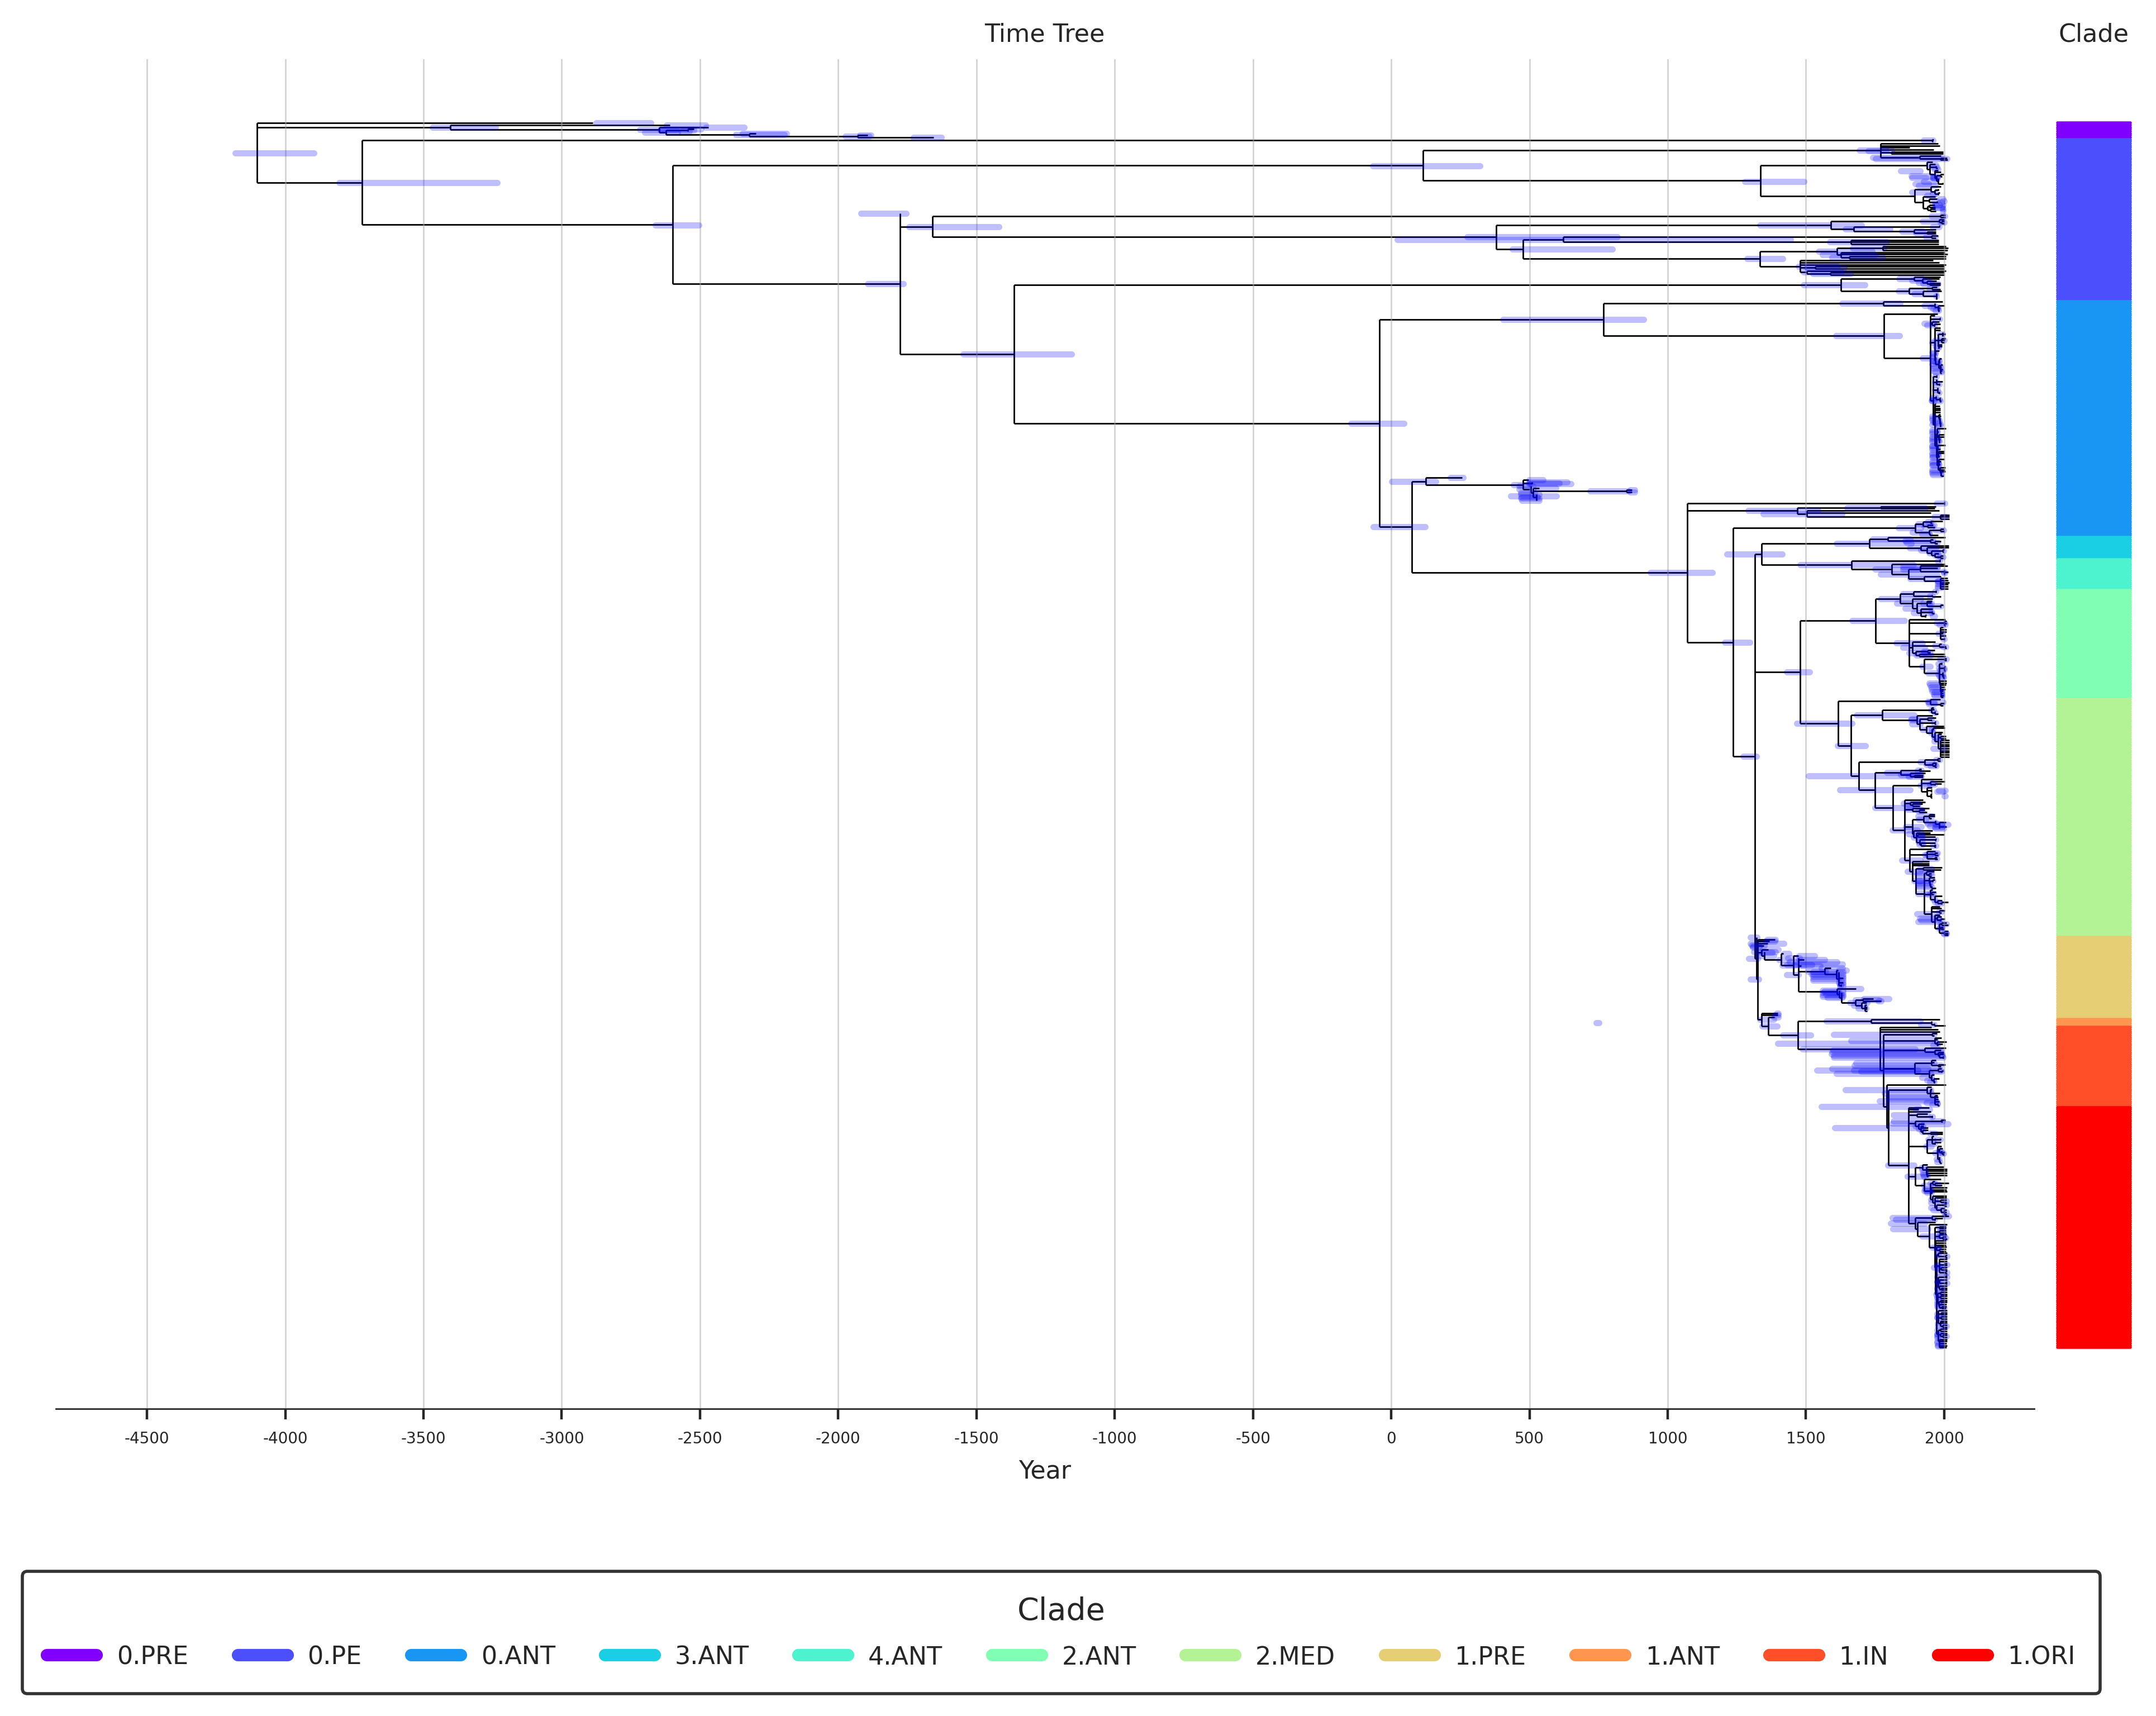

In [172]:
# --------------------------------------------
# Setup
plt.rc("lines", linewidth=0.25)

# --------------------------------------------
# Data
tt_copy.branch_length_to_years()

# reset color
for c in tt_copy.tree.find_clades():
    c.color = "black"
    
plt.rc("lines", linewidth=0.5)
Phylo.draw(tt_copy.tree,
           axes=axes[0], 
           show_confidence=False, 
           label_func = lambda x:'', 
           #label_func = lambda x : tree_df["Branch_Major"][x.name],
          )

# --------------------------------------------
# Labels
ax_tree.set_xlabel("Year")
ax_tree.set_ylabel("")
ax_tree.set_yticks([])


# --------------------------------------------
# Limits (again)        
ax_tree.set_xlim(x_min - x_buffer - x_buffer, ticks_dict["tick_locs"][-1] + x_buffer)
ax_tree.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

fig_timetree

## Save

In [173]:
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + FMT)
fig_timetree.savefig(out_path, dpi=dpi, bbox_inches = "tight")
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + "jpg")
fig_timetree.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# 4. Plot Rate Variation

In [ ]:
"""# Set branch length to mutations
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
min_gamma = min(tree_df["timetree_rate_fold_change"])
max_gamma = max(tree_df["timetree_rate_fold_change"])
gamma_range = max_gamma - min_gamma

GAMMA_COL_PAL = {
    0: "#000000", # black
    1: "#facb35", # yellow
    2: "#ff8800", # orange
    3: "#ff0000"} # red

for c in tt_copy.tree.find_clades():
    if not hasattr(c.branch_length_interpolator, "gamma"):
        c.color = GAMMA_COL_PAL[0]
        continue
    gamma = c.branch_length_interpolator.gamma
    # Switch Case
    if gamma >= 0 and gamma < 1:
        c.color = GAMMA_COL_PAL[0]
    elif gamma >= 1 and gamma < 2:
        c.color = GAMMA_COL_PAL[1]    
    elif gamma >= 2 and gamma < 3:
        c.color = GAMMA_COL_PAL[2]     
    elif gamma >= 3:
        c.color = GAMMA_COL_PAL[3] 

# Setup plot
plt.rc("lines", linewidth=1)
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)

Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Labels
ax1.set_xlabel("Branch Length")
ax1.set_ylabel("")
ax1.set_yticks([])
plt.title("Divergence Tree")

# --------------------------------------------
# Limits
coord_x = [x for x in tree_df["coord_x"] if x != NO_DATA_CHAR]
x_buffer = max(coord_x) * 0.05
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(coord_x) + x_buffer)
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-rate." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")"""